# RF Resonator
#### Author: Ke Sun

In [2]:
%matplotlib inline
#%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve

## 3D plot of total impedance and voltage at trap in terms of trap frequency and matching capacitance

In [19]:
N = 501
# Frequency: MHz
fs = np.linspace(40,60,N)

# Capacitance: uF
# Inductance: uH
Cms = np.linspace(1e-4, 1.5e-3,N)
fs, Cms = np.meshgrid(fs, Cms)

def LC_circuit(f, Cm):
    R, Rt = 0.5, 0.1 # Ohm
    Ct, Cb = 25.8e-6, 0.1e-6 # uF
    L, Ltrace1, Ltrace2 = 0.530, 0, 0 # uH
    
    w = 2*np.pi*f
    Xct, Xcm = 1/(w*Ct), 1/(w*Cm)
    XL, XLtrace1, XLtrace2 = w*L, w*Ltrace1, w*Ltrace2

    Ztb = -1j * Xct + Rt      # impedance of trap and CPGA board (didn't include Cb here)
    Ztrace1 = 1j * XLtrace1   # impedance of trace on the left of Cm
    Ztrace2 = 1j * XLtrace2   # impedance of trace on the right of Cm
    ZL = 1j*XL
    Z1 = R + ZL + Ztb + Ztrace2 # impedance of those components on the right of Cm
    Z2 = -1j*Xcm
    Zt = (Z1*Z2)/(Z1 + Z2) + Ztrace1 # impedance of all the components
    ReZt = np.real(Zt)
    ImZt = np.imag(Zt)
    AbsZt = np.abs(Zt)
    
    V = 1 # input voltage
    Vt = V * (Zt/(Zt+50))*((Zt-Ztrace1)/Zt)*(Ztb/(R + ZL + Ztb + Ztrace2))
    return AbsZt, Vt

AbsZt, Vt = LC_circuit(fs, Cms)

def plot_3d(fs, Cms, value):
    fcolors = value
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors-fmin)/max((fmax-fmin),1e-5)
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(fs, Cms, value, linewidth=0, facecolors=cm.jet(fcolors))
    plt.show() 

3D plot of total impedance in terms of frequency (f) and matching capacitance (Cm) 

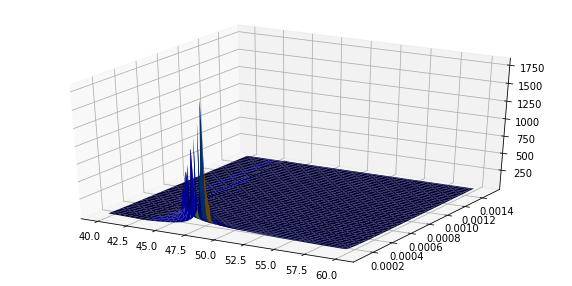

In [20]:
plot_3d(fs, Cms, AbsZt)

3D plot of voltage gain in terms of frequency (f) and matching capacitance (Cm) 

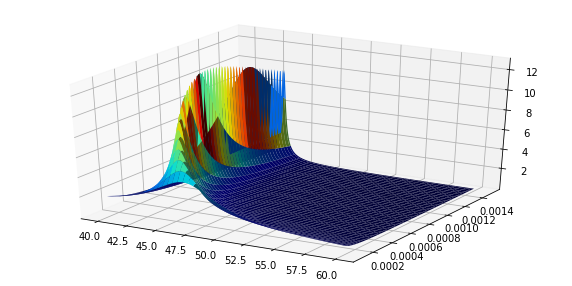

In [21]:
AbsVt = np.abs(Vt)
plot_3d(fs, Cms, AbsVt)

2D plot of voltage gain in terms of matching capacitance (Cm)

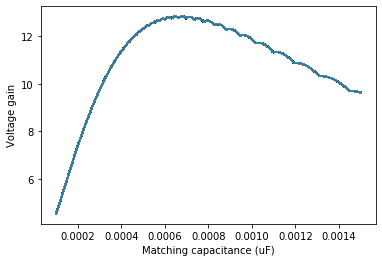

In [22]:
gain1 = np.amax(AbsVt, axis=1) # voltage gain vs. Cm
gain2 = np.amax(AbsVt, axis=0) # voltage gain vs. f

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Cms, gain1)
plt.xlabel('Matching capacitance (uF)')
plt.ylabel('Voltage gain')
plt.show()

## Simulate the influence of R and Rt, calculate Q

In [27]:
class Resonator:
    def __init__(self, 
                 Ct = 7.75e-6, # uF
                 L = 0.966, # uH
                 N = 1001):
        self.N = N
        self.Ct = Ct # uF
        self.L = L
        self.Ltrace1 = 0
        self.Ltrace2 = 0
        
    def absVt(self, 
              f, 
              Cm, 
              R, # resistance of inductor
              Rt # resistance of trap
             ):
        w = 2*np.pi*f
        Xct, Xcm = 1/(w*self.Ct), 1/(w*Cm)
        XL, XLtrace1, XLtrace2 = w*self.L, w*self.Ltrace1, w*self.Ltrace2

        Ztb = -1j * Xct + Rt
        Ztrace1 = 1j * XLtrace1
        Ztrace2 = 1j * XLtrace2
        ZL = 1j*XL
        Z1 = R + ZL + Ztb + Ztrace2
        Z2 = -1j*Xcm
        Zt = (Z1*Z2)/(Z1 + Z2) + Ztrace1

        V = 1
        Vt = V * (Zt/(Zt+50))*((Zt-Ztrace1)/Zt)*(Ztb/(R + ZL + Ztb + Ztrace2))
        return np.abs(Vt)
    
    def relationWithCm(self,
                      R = 0.1,
                      Rt = 0.1,
                      pos = 111, #position of subplot
                      Cms = np.linspace(0.1e-4, 1.5e-3,1001)
                      ):
        freqs = np.linspace(40,80,self.N)
        i,j = 0,0
        absvt = np.zeros((self.N,2*self.N))
        for f in freqs:
            for Cm in Cms:
                absvt[i][j] = self.absVt(f, Cm, R, Rt)
                j+= 1
            i+=1
            j=0

        center_freq = []
        gain = []
        for j in range(len(Cms)):
            gain.append(max(absvt[:,j]))# Calculate Gain:
            center_freq.append(freqs[np.argmax(absvt[:,1])])# Find center frequency
        
        MatchCap = Cms[np.argmax(gain)]# Find center frequency

        # Plot
        fig = plt.figure()
        ax = fig.add_subplot(pos)
        ax.plot(Cms, gain)
        plt.ylabel('Voltage gain')
        title = "R_L = {} Ohm, R_trap = {} Ohm".format(R, Rt)
        plt.title(title)
        '''fig = plt.figure()
        ax = fig.add_subplot(212)
        ax.plot(Cms, center_freq)
        plt.ylabel('Center frequency (MHz)')'''
        plt.xlabel('Matching capacitance (uF)')
        
        '''name = "RL_{:.2}_Rtrap_{:.2}.png".format(R, Rt)
        fig.savefig(name) # Save figures'''
        #plt.close(fig) 
        plt.show()    
        return MatchCap
        
        
    def CalculateQ(self,
                   freqs,
                   Cm,
                   R,
                   Rt
                  ):
        interval = np.abs(freqs[1]-freqs[0]) # interval of frequency sequence
        
        Vt = self.absVt(freqs, Cm, R, Rt)
        maxVt = np.max(Vt)
        fc = freqs[np.argmax(Vt)]
        halfVt = maxVt/np.sqrt(2)
        idx = (np.abs(Vt-halfVt)).argmin()
        f1 = freqs[idx]
        newVt = np.delete(Vt, idx)
        newfreqs = np.delete(freqs, idx)
        idx = (np.abs(newVt-halfVt)).argmin()
        f2 = newfreqs[idx]
        while 0.5 * np.abs(f1-f2) < interval:
            newVt = np.delete(newVt, idx)
            newfreqs = np.delete(newfreqs, idx)
            idx = (np.abs(newVt-halfVt)).argmin()
            f2 = newfreqs[idx]
        Q = fc/np.abs(f1-f2)
        return Q, fc

### Simulate the influence of R and Rt

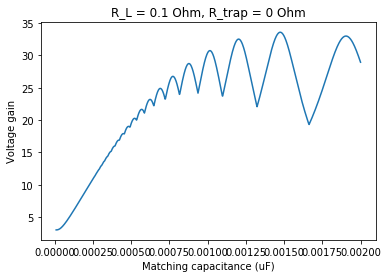

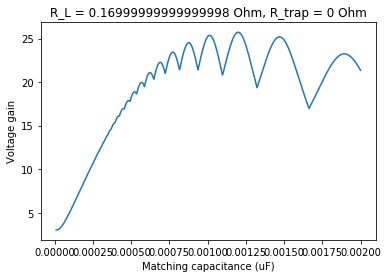

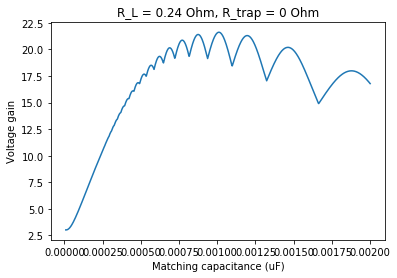

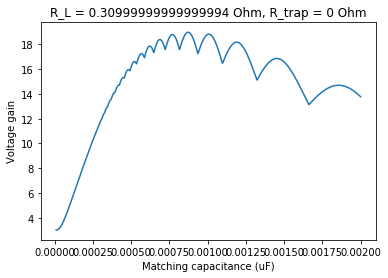

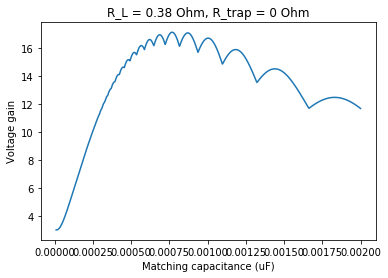

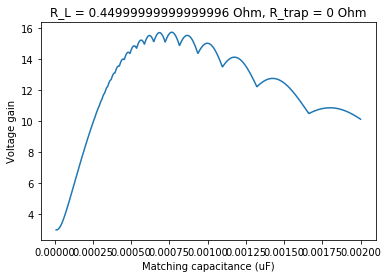

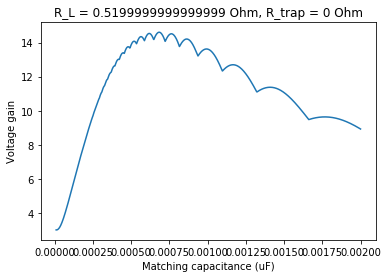

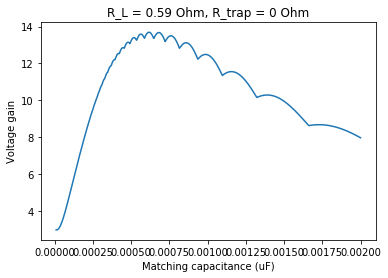

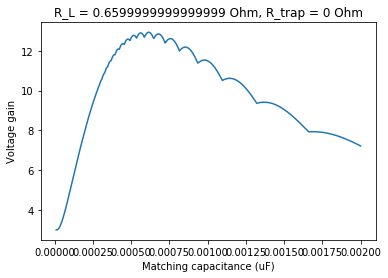

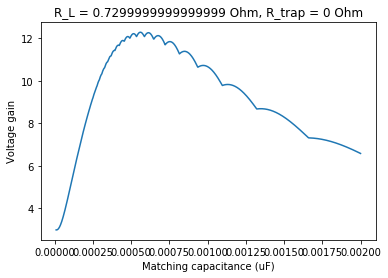

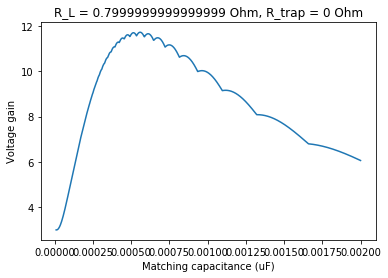

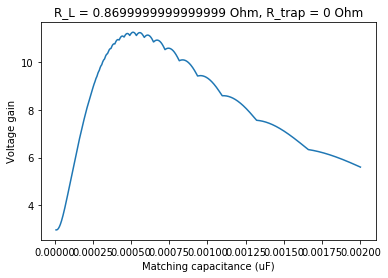

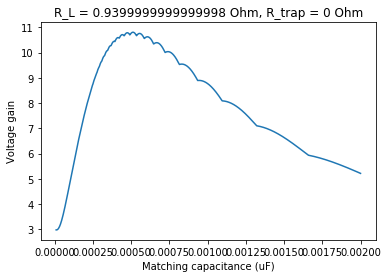

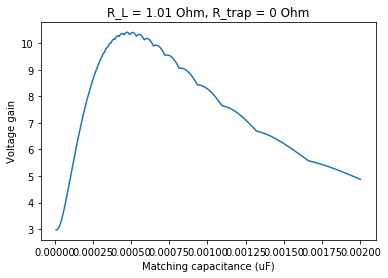

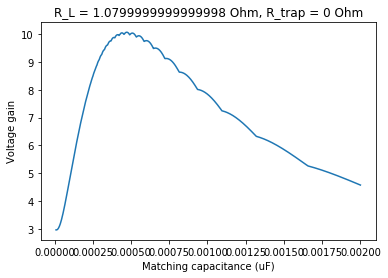

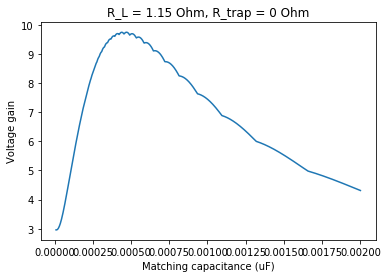

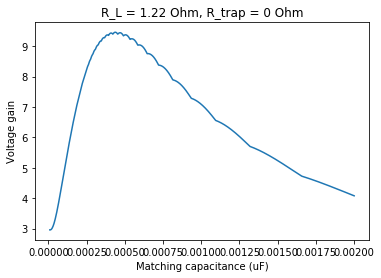

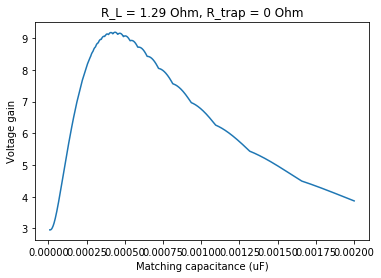

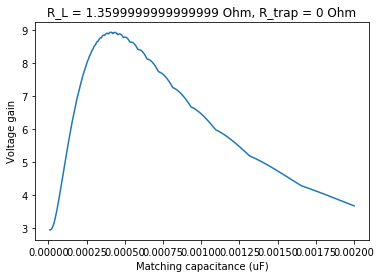

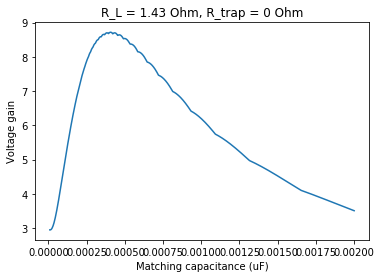

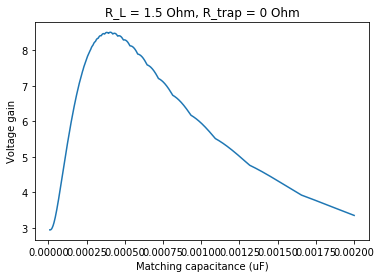

Text(0, 0.5, 'Matching capacitance (uF)')

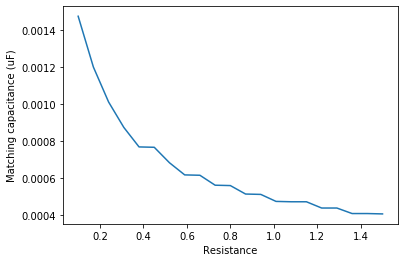

In [33]:
test = Resonator(Ct = 23.1e-6, # uF
                 L = 0.53,
                 N = 501)
Rs = np.linspace(0.1,1.5,21)
Rts = np.linspace(0,0,1)
MatchCaps = []
for R in Rs:
    MatchCaps.append(test.relationWithCm(R = R, Rt = 0, pos = 111,Cms = np.linspace(0.1e-4, 20e-4,1001)))
plt.plot(Rs, MatchCaps)
plt.xlabel('Resistance')
plt.ylabel('Matching capacitance (uF)')

In [39]:
for i in range(len(MatchCaps)):
    print(str(round(Rs[i],3))+'Ohm'+', '+str(round(MatchCaps[i]*1e6,3))+'pF')

0.1Ohm, 1474.64pF
0.17Ohm, 1200.02pF
0.24Ohm, 1010.97pF
0.31Ohm, 873.66pF
0.38Ohm, 768.19pF
0.45Ohm, 766.2pF
0.52Ohm, 682.62pF
0.59Ohm, 616.95pF
0.66Ohm, 614.96pF
0.73Ohm, 561.23pF
0.8Ohm, 559.24pF
0.87Ohm, 513.47pF
0.94Ohm, 511.48pF
1.01Ohm, 473.67pF
1.08Ohm, 471.68pF
1.15Ohm, 471.68pF
1.22Ohm, 437.85pF
1.29Ohm, 437.85pF
1.36Ohm, 408.0pF
1.43Ohm, 408.0pF
1.5Ohm, 406.01pF


### Claculate Q

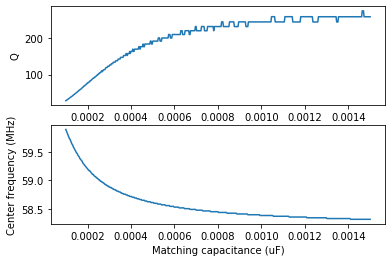

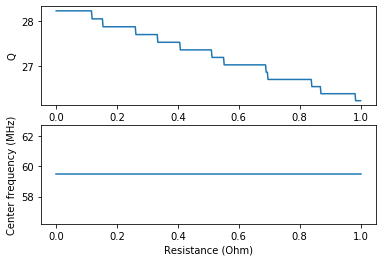

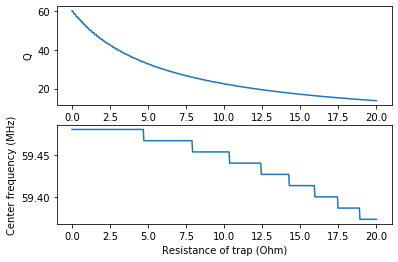

In [29]:
R = 0.3
Rt = 1
Cms = np.linspace(1e-4, 1.5e-3, 501)
freqs = np.linspace(40,80,3001)
Rs = np.linspace(0, 1, 501)
Rts = np.linspace(0, 20, 501)

# Q vs. Cm
QCm = []
fCm = []
for Cm in Cms:
    Q, fc = test.CalculateQ(freqs, Cm, R, Rt)
    QCm.append(Q)
    fCm.append(fc)

# Q vs. R
Rt = 7
QR = []
fR = []
Cm = 1.5e-4
for R in Rs:
    Q, fc = test.CalculateQ(freqs, Cm, R, Rt)
    QR.append(Q)
    fR.append(fc)

# Q vs. Rt
R = 0.3
QRt = []
fRt = []
Cm = 1.5e-4
for Rt in Rts:
    Q, fc = test.CalculateQ(freqs, Cm, R, Rt)
    QRt.append(Q)
    fRt.append(fc)    

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(Cms, QCm)
plt.ylabel('Q')
ax = fig.add_subplot(212)
ax.plot(Cms, fCm)
plt.xlabel('Matching capacitance (uF)')
plt.ylabel('Center frequency (MHz)')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(Rs, QR)
plt.ylabel('Q')
ax = fig.add_subplot(212)
ax.plot(Rs, fR)
plt.xlabel('Resistance (Ohm)')
plt.ylabel('Center frequency (MHz)')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(Rts, QRt)
plt.ylabel('Q')
ax = fig.add_subplot(212)
ax.plot(Rts, fRt)
plt.xlabel('Resistance of trap (Ohm)')
plt.ylabel('Center frequency (MHz)')
plt.show()

### Smaller copper

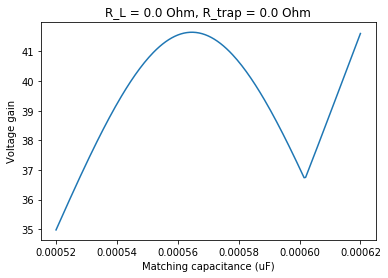

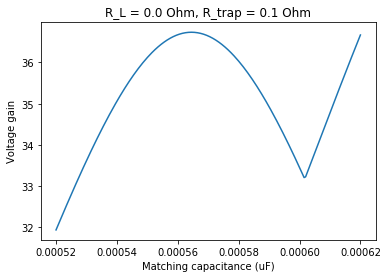

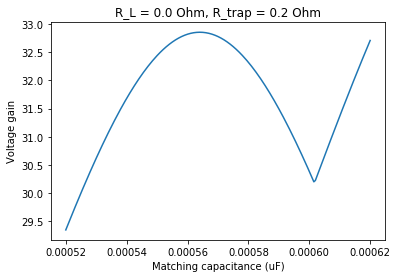

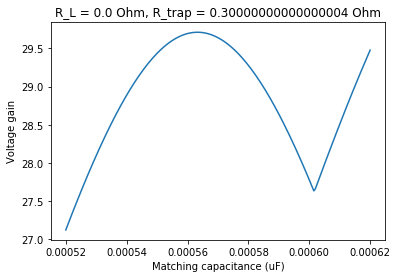

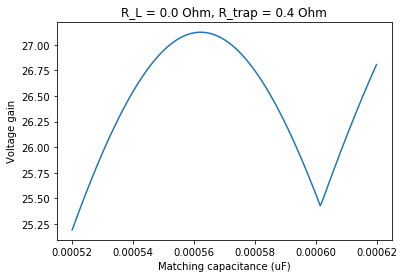

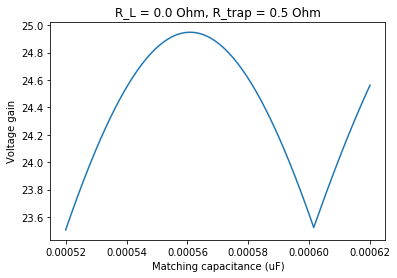

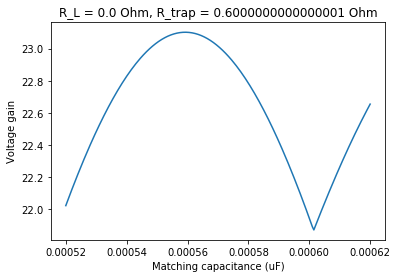

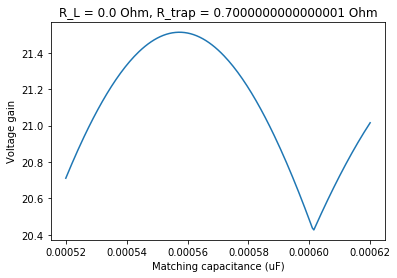

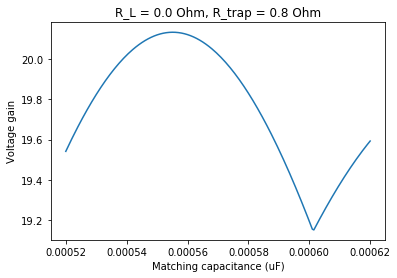

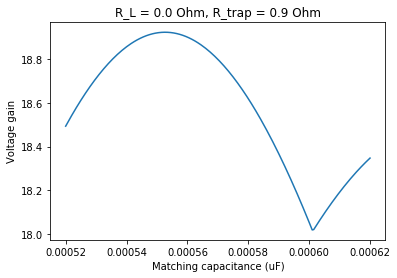

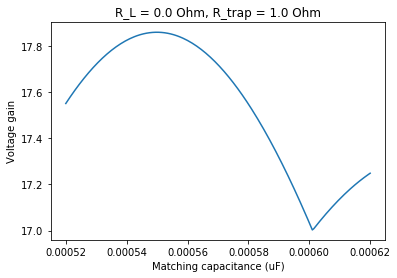

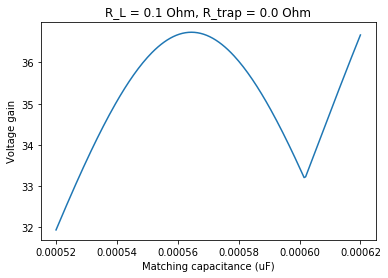

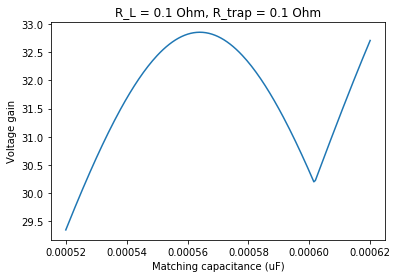

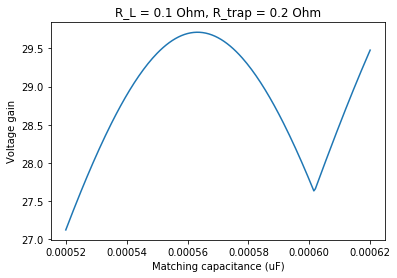

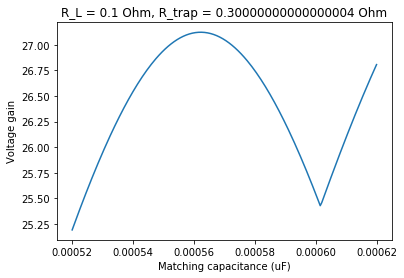

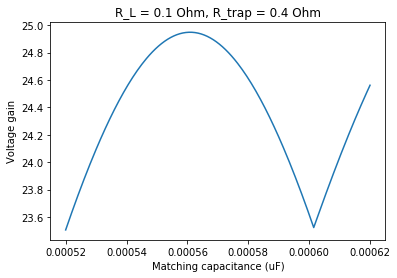

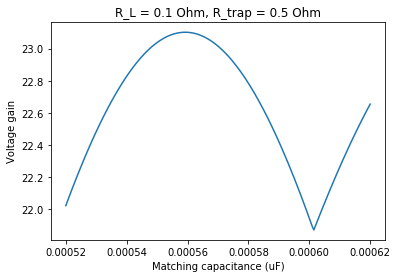

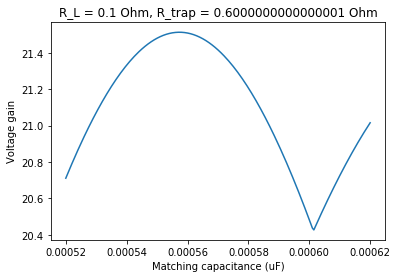

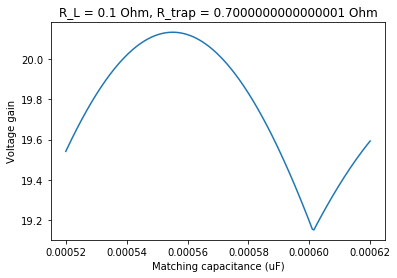

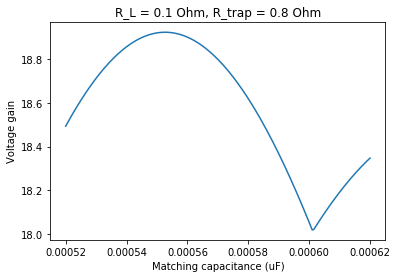

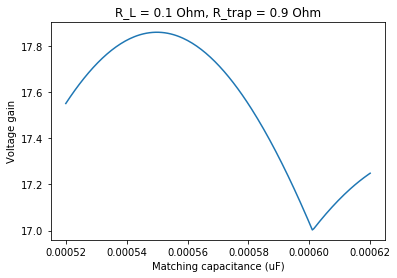

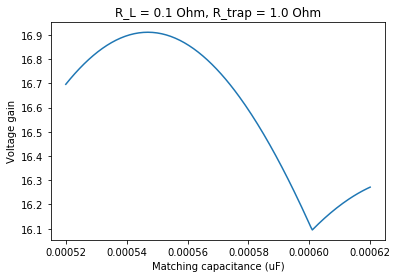

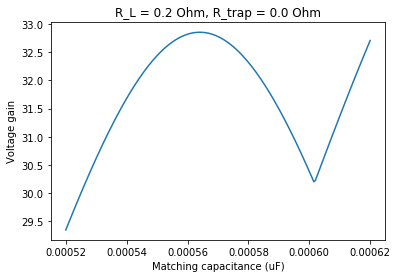

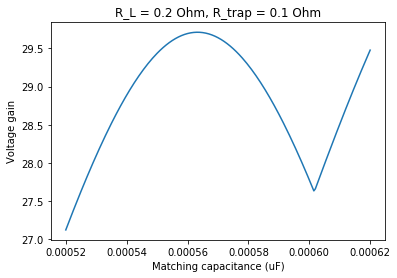

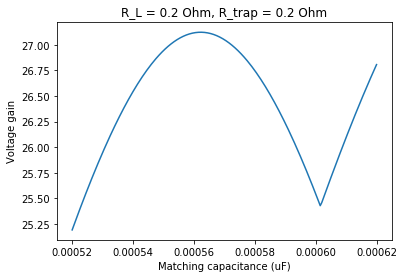

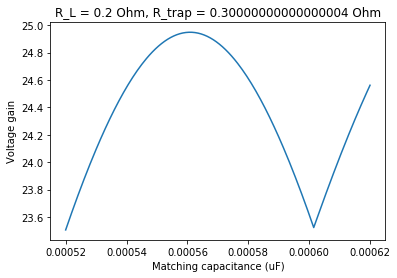

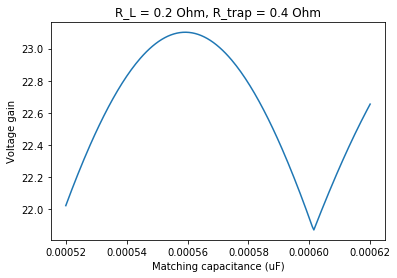

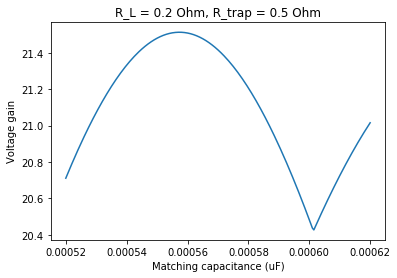

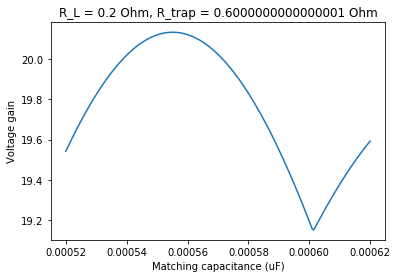

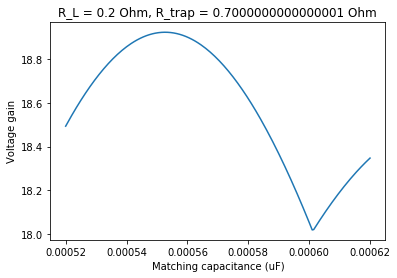

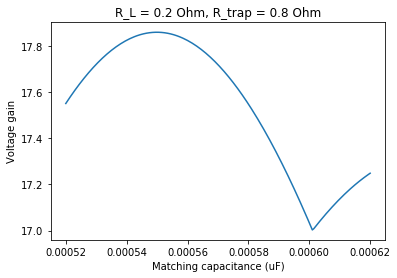

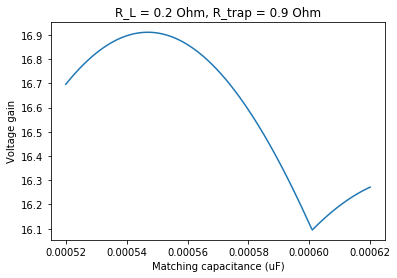

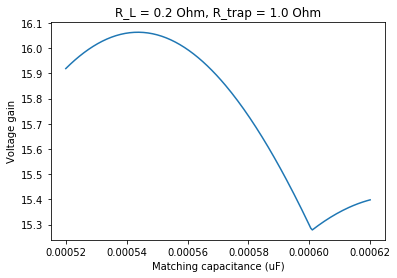

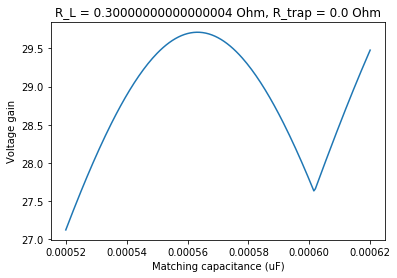

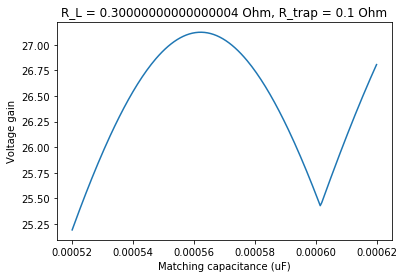

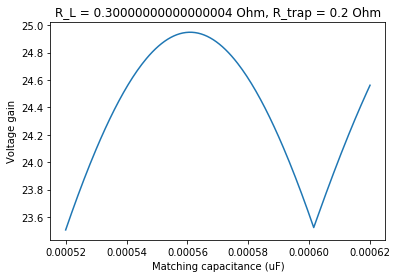

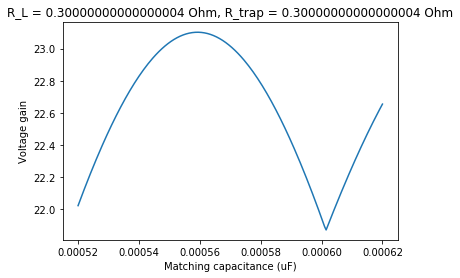

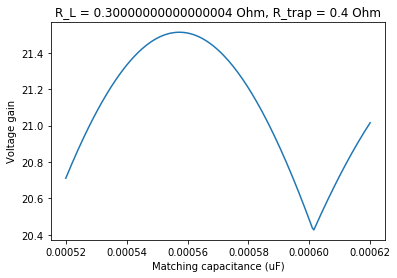

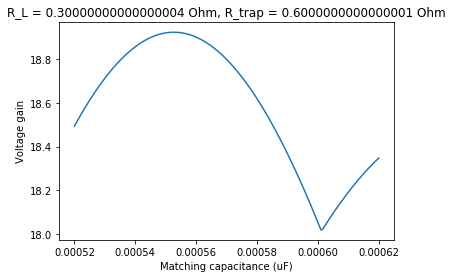

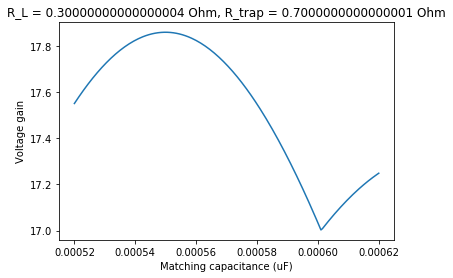

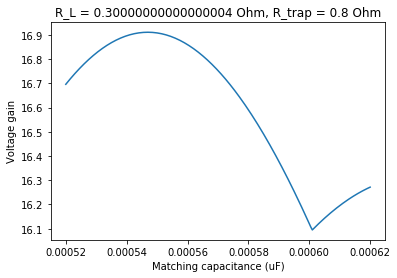

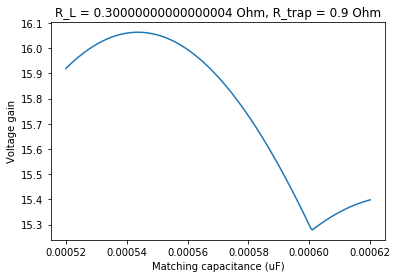

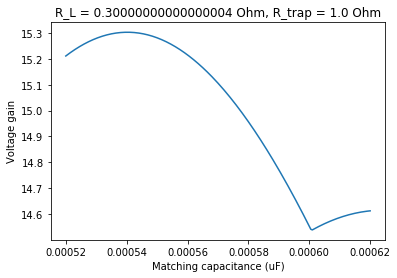

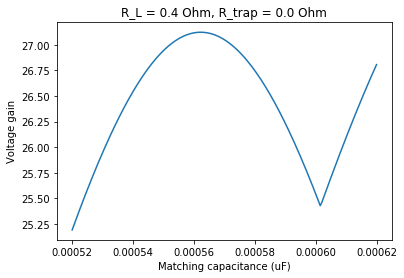

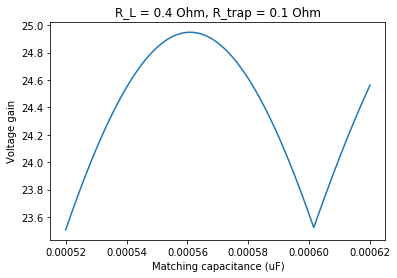

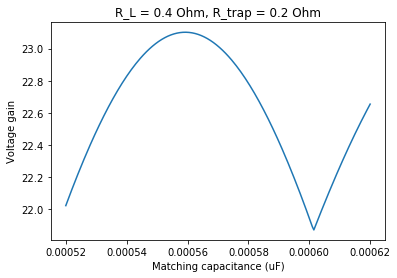

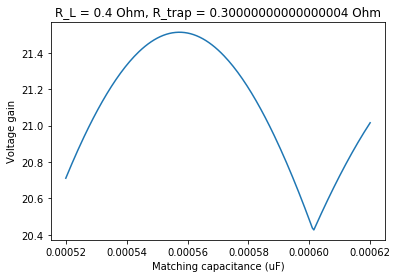

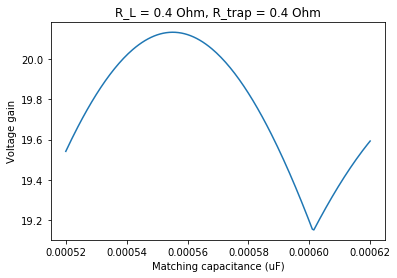

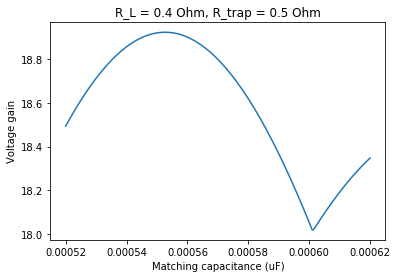

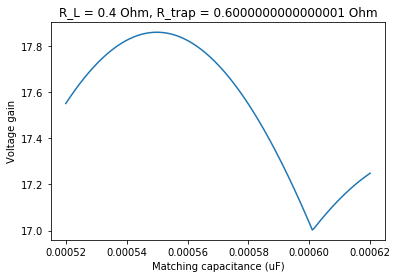

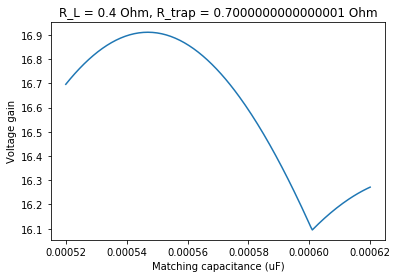

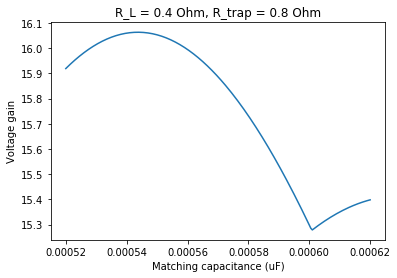

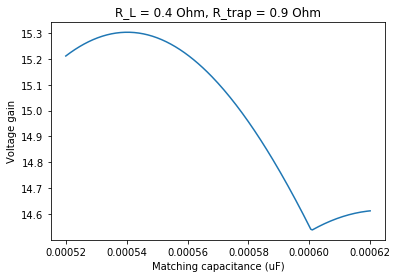

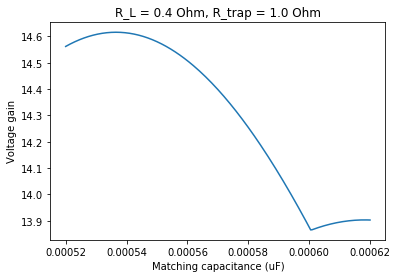

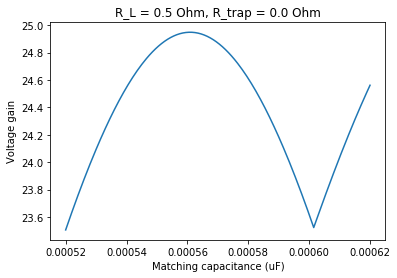

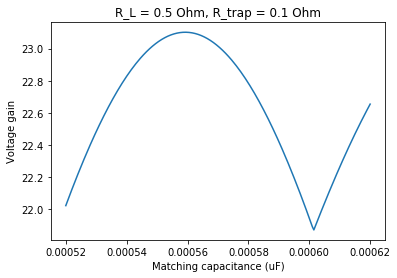

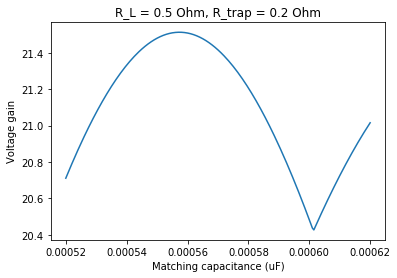

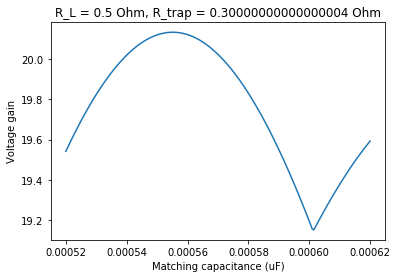

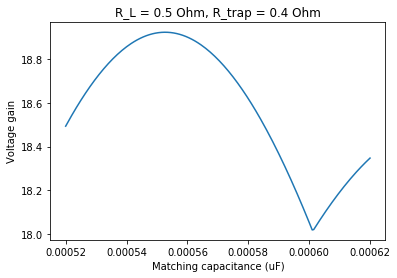

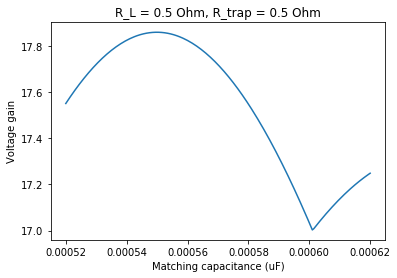

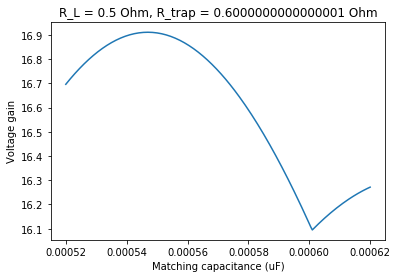

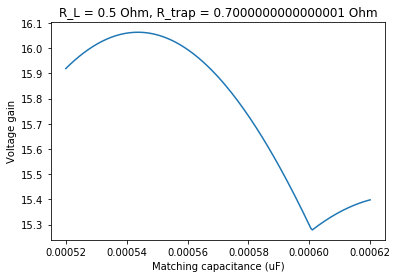

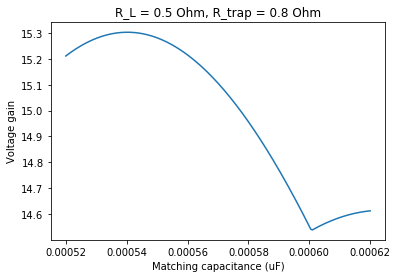

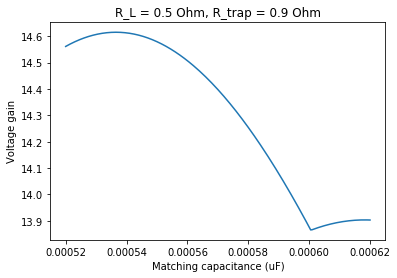

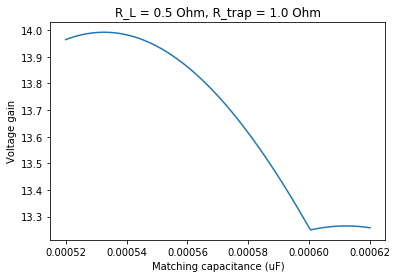

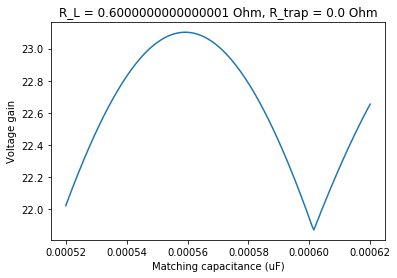

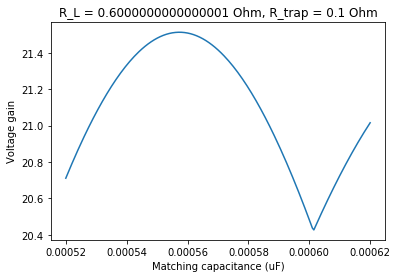

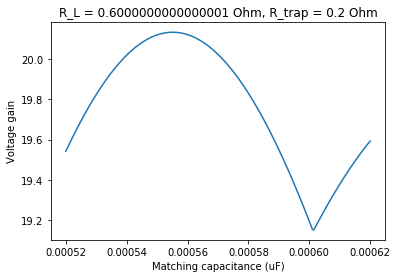

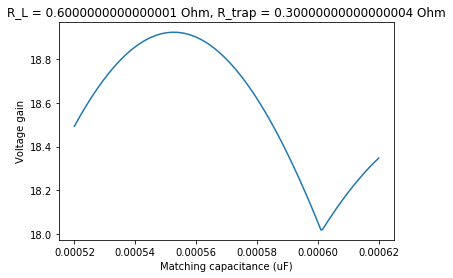

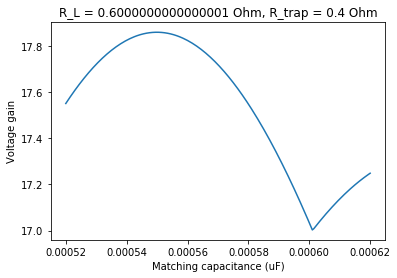

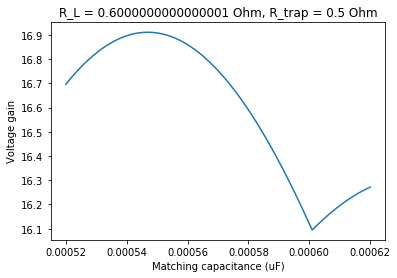

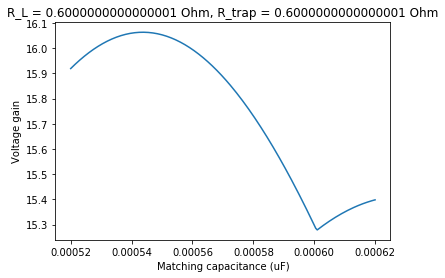

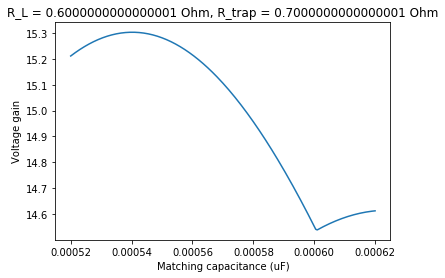

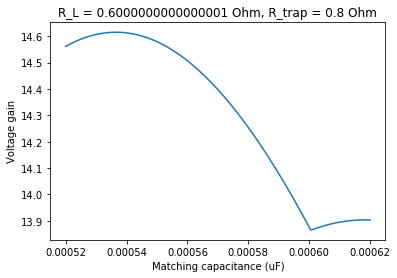

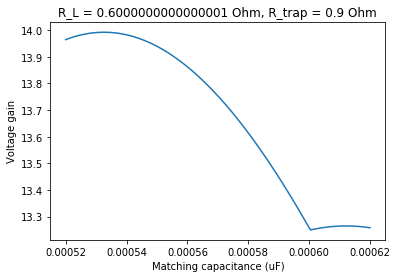

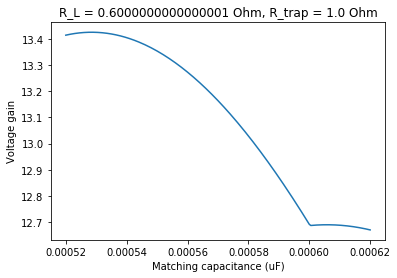

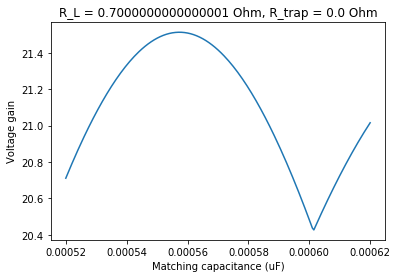

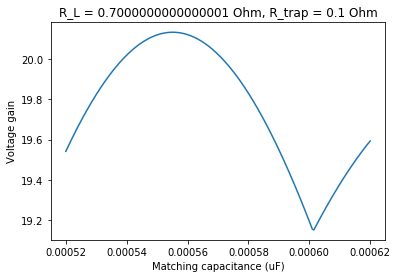

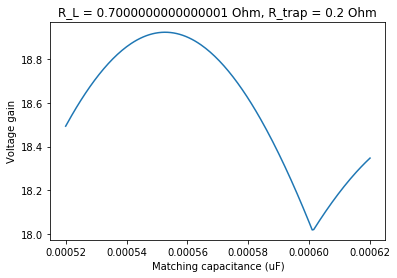

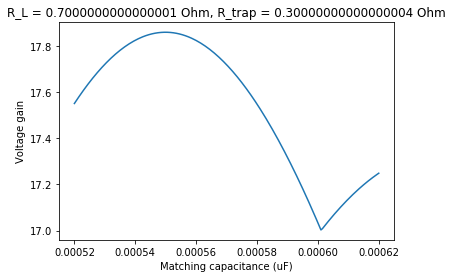

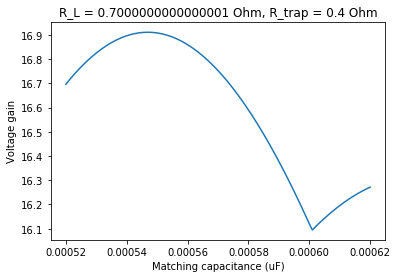

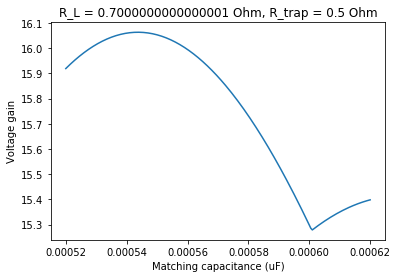

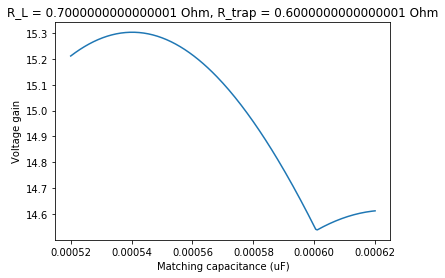

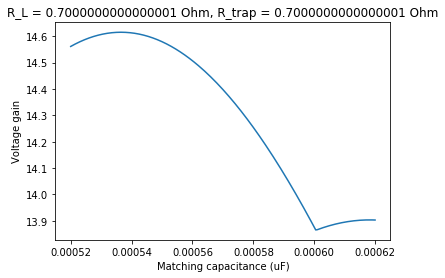

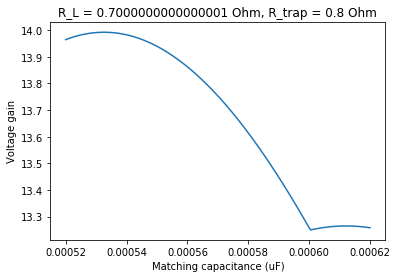

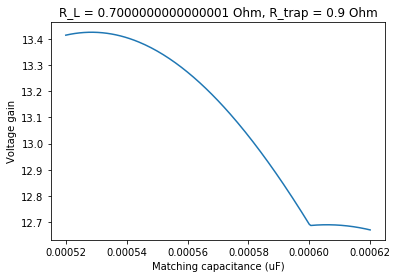

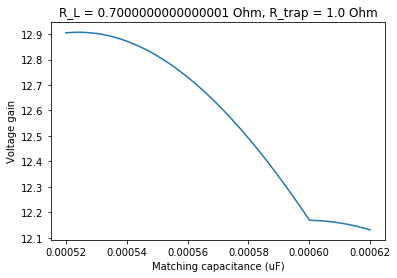

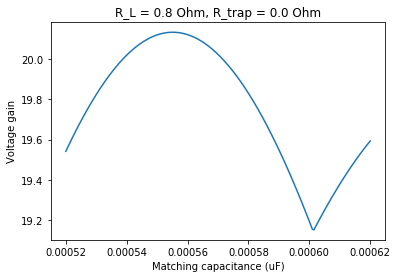

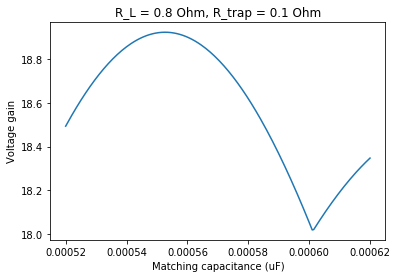

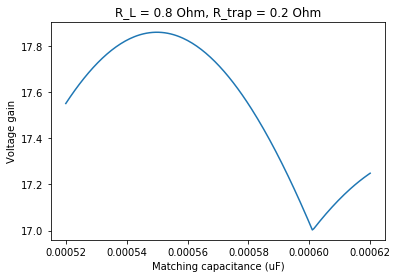

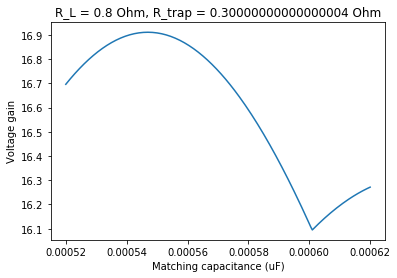

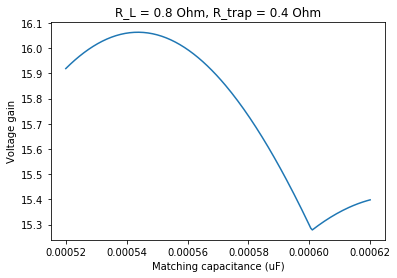

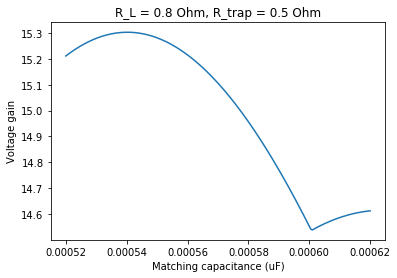

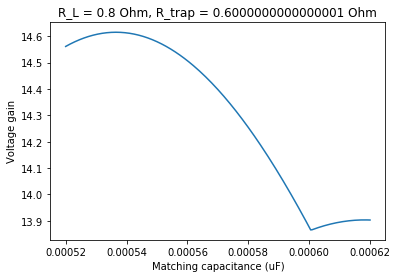

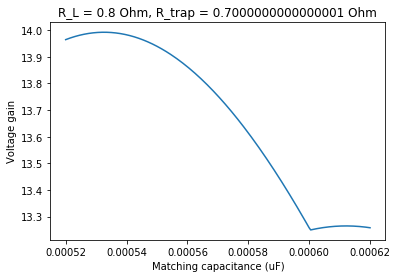

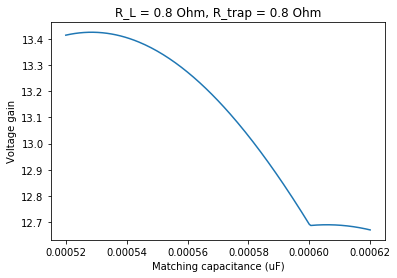

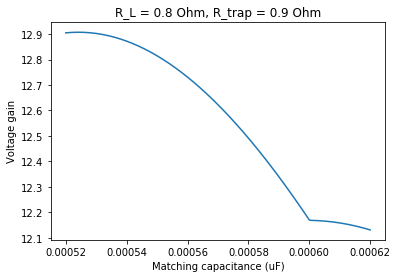

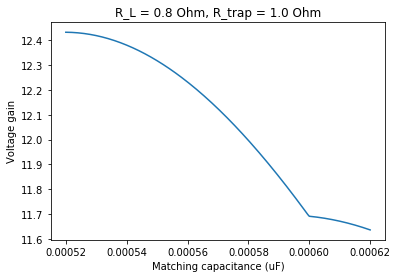

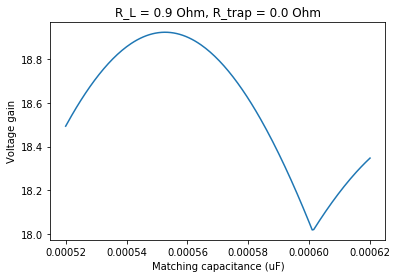

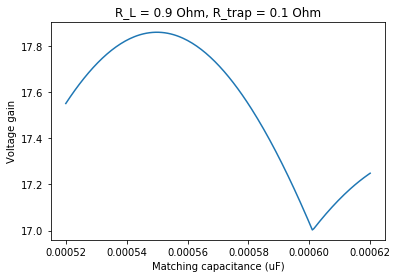

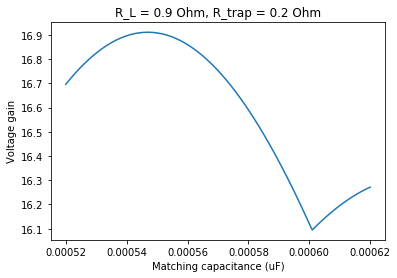

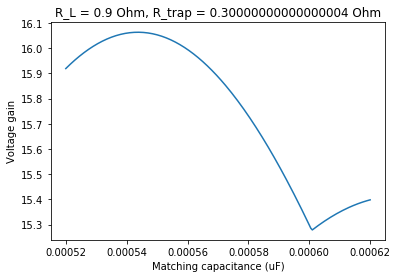

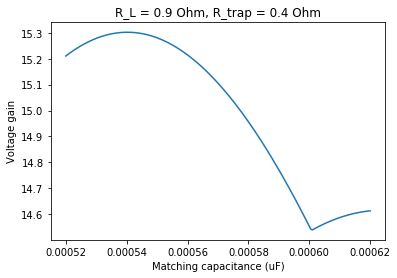

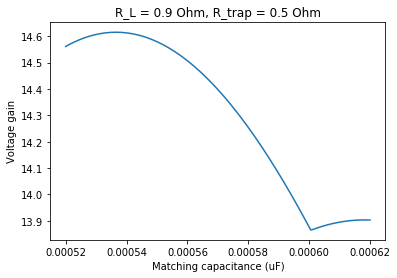

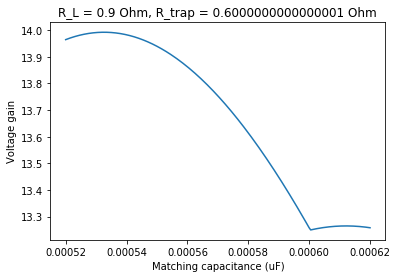

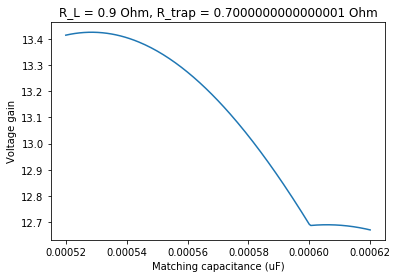

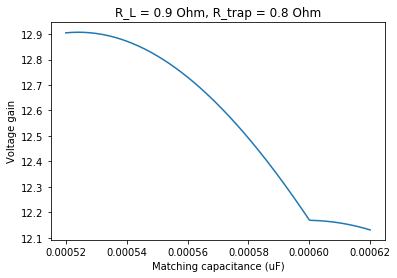

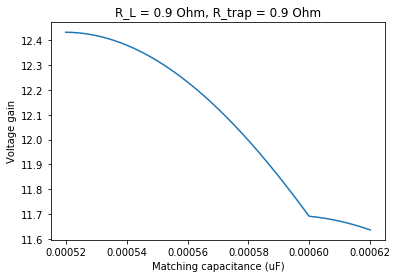

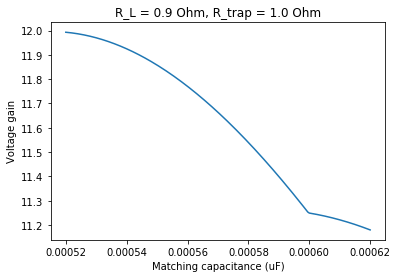

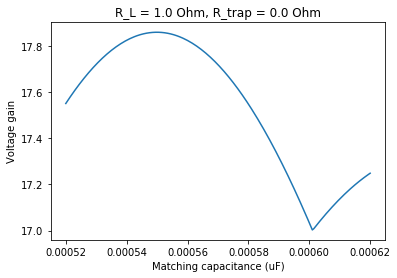

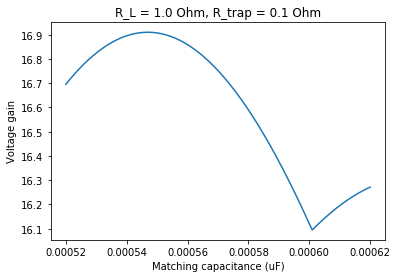

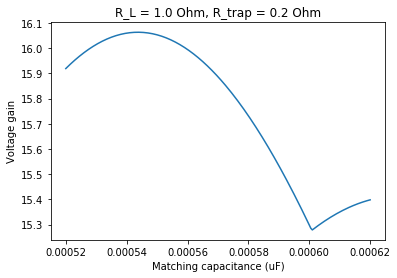

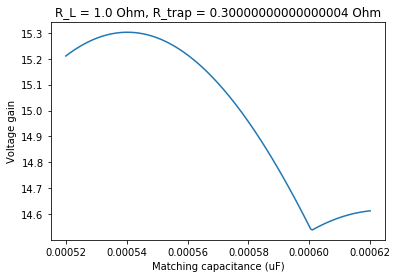

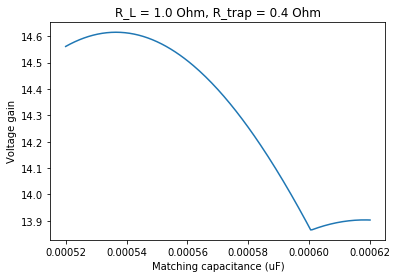

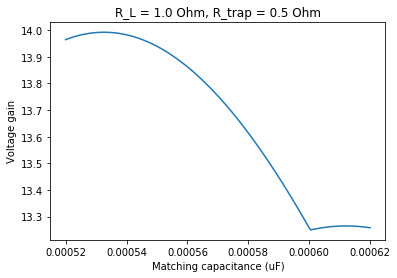

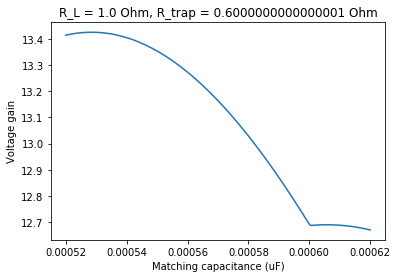

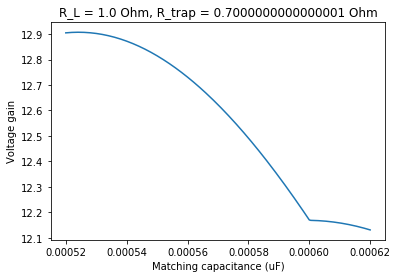

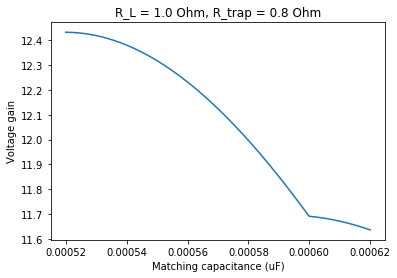

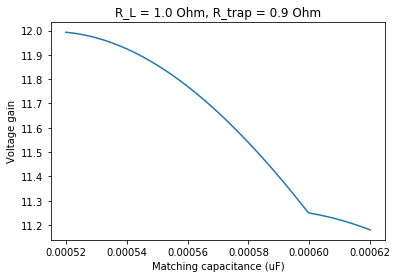

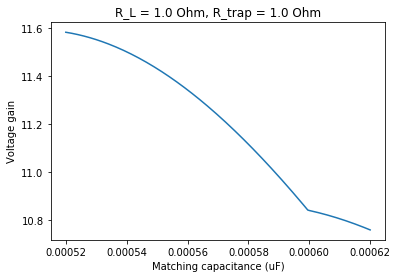

In [86]:
test = Resonator(Ct = 13.558e-6, # uF
                 L = 0.901,
                 N = 501)
Rs = np.linspace(0,1,11)
Rts = np.linspace(0,1,11)
for R in Rs:
    for Rt in Rts:
        test.relationWithCm(R = R, Rt = Rt, pos = 111,Cms = np.linspace(5.2e-4, 6.2e-4,201))

### Thick SC

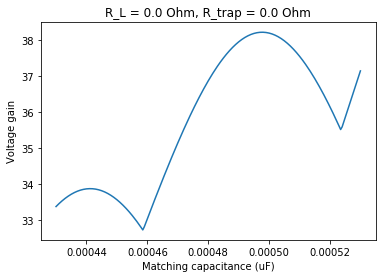

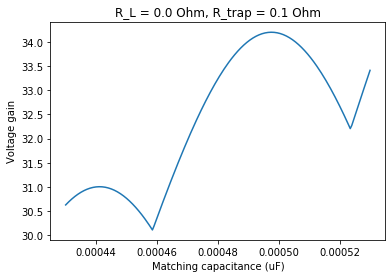

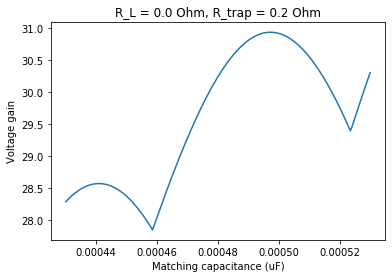

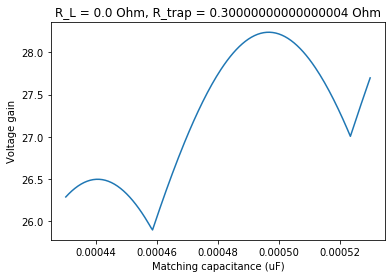

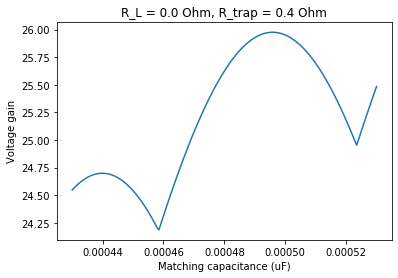

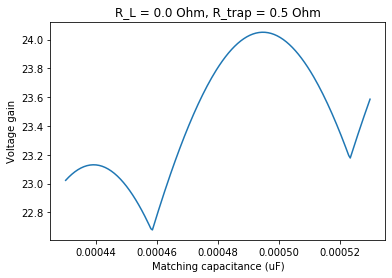

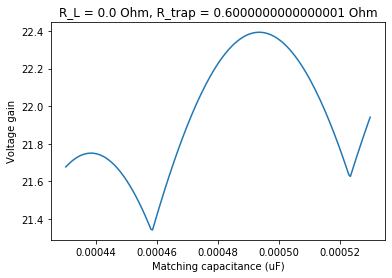

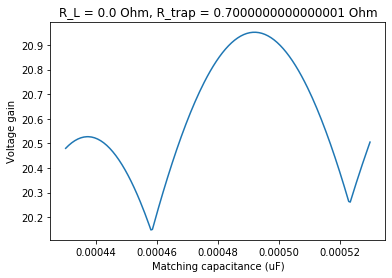

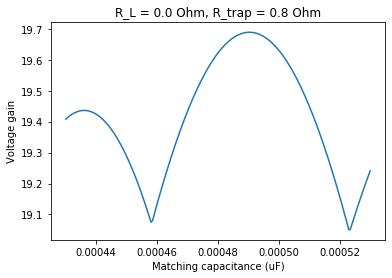

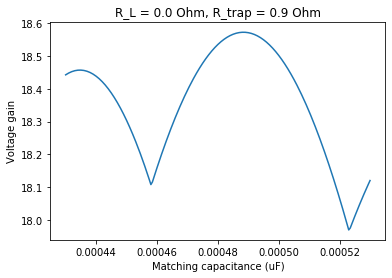

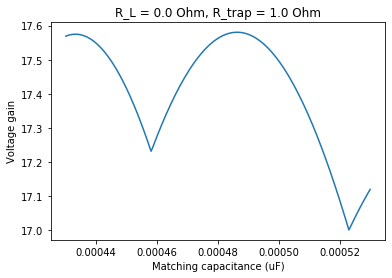

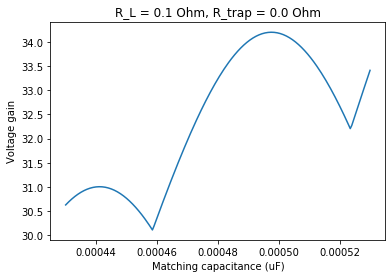

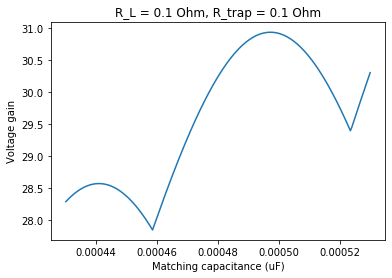

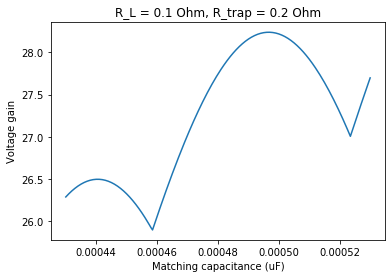

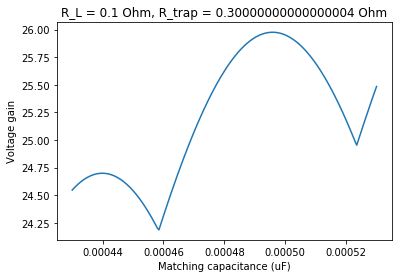

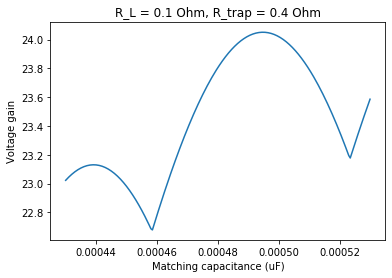

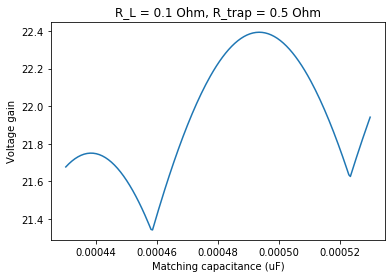

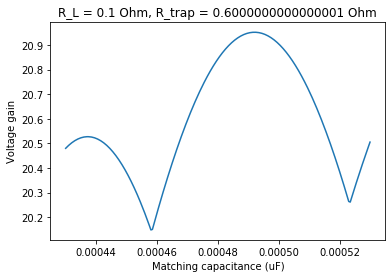

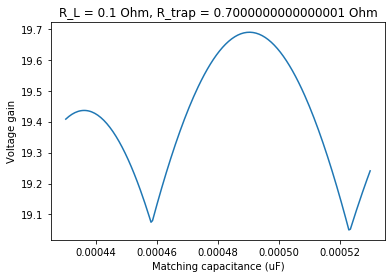

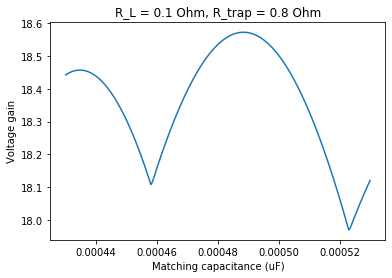

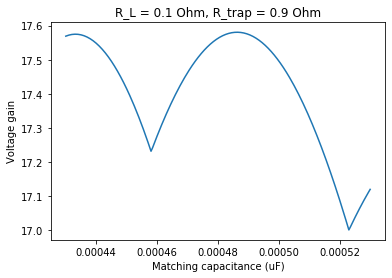

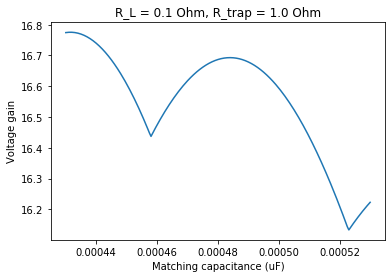

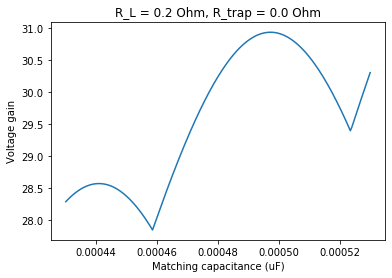

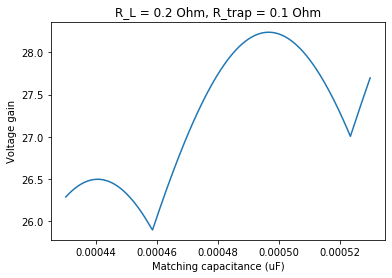

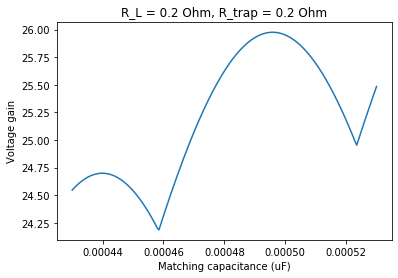

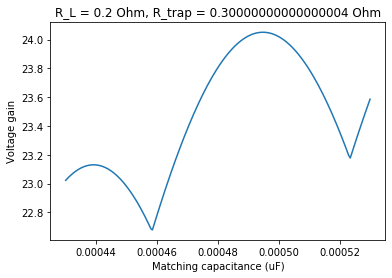

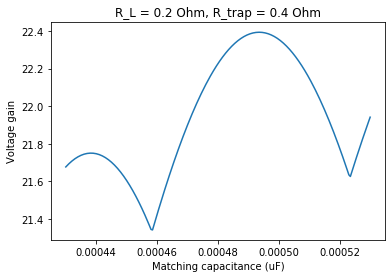

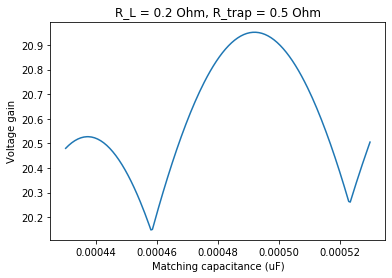

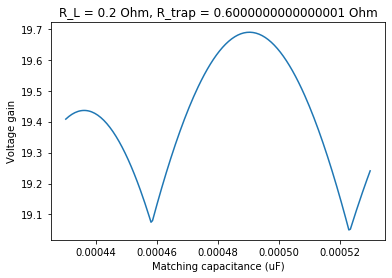

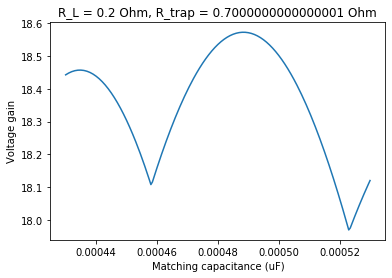

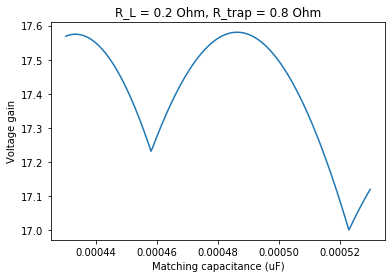

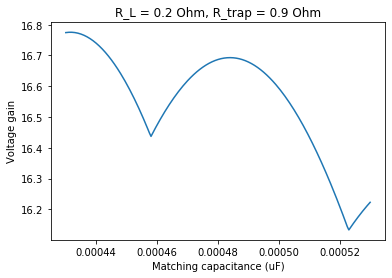

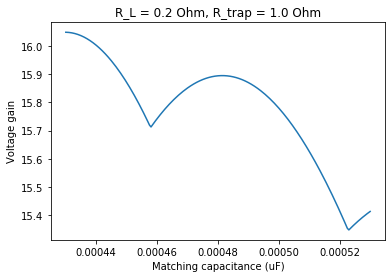

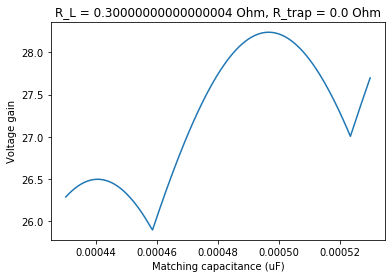

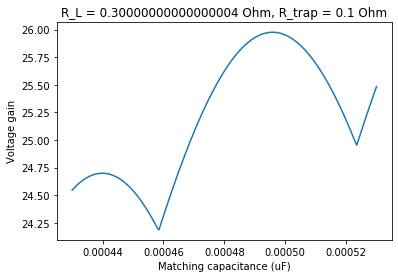

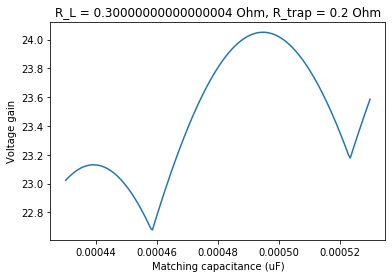

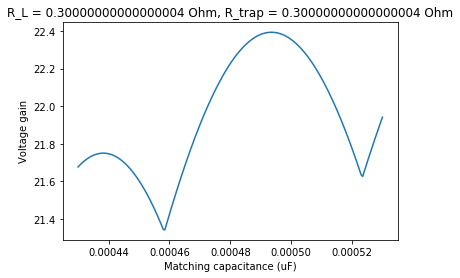

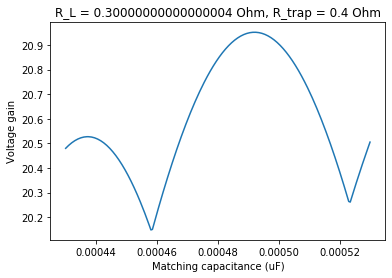

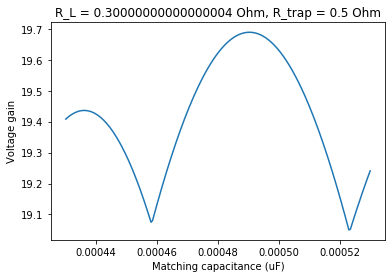

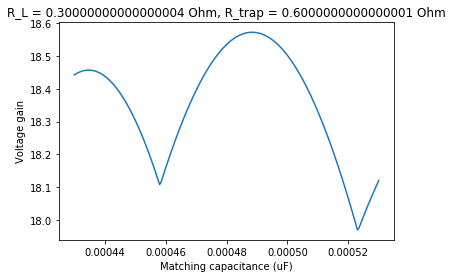

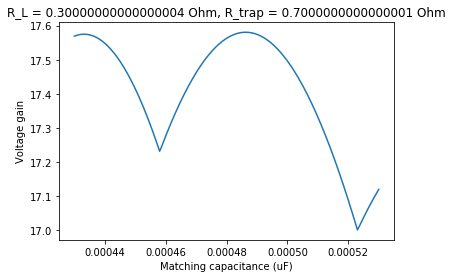

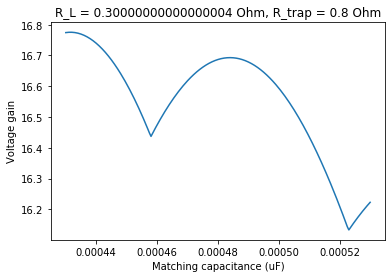

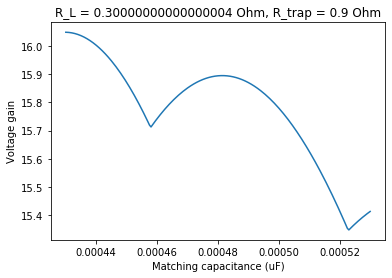

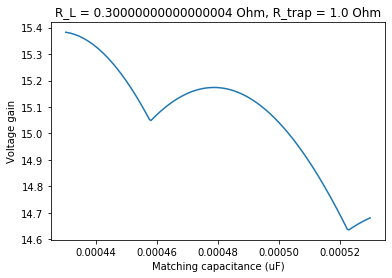

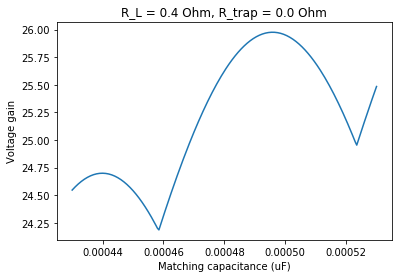

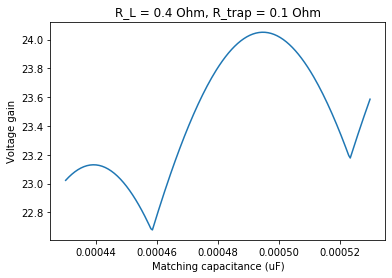

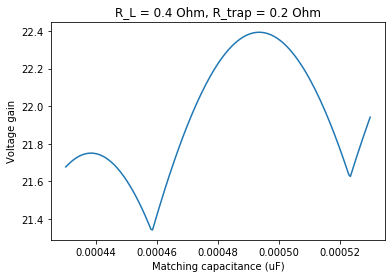

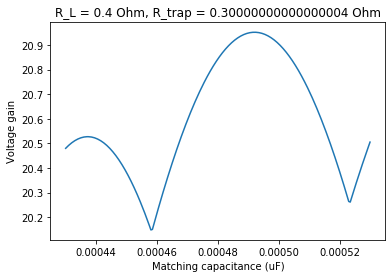

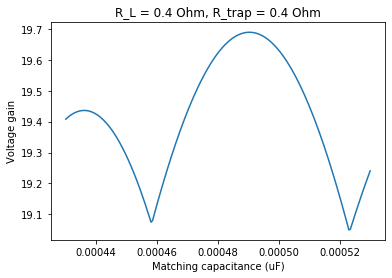

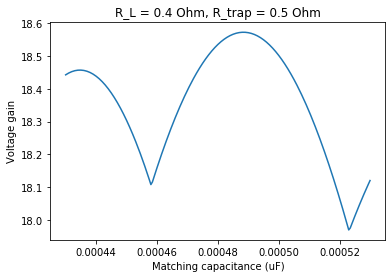

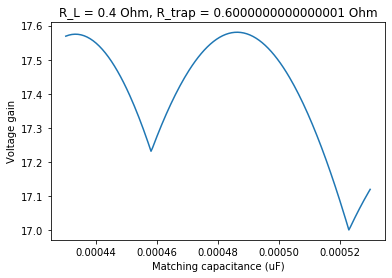

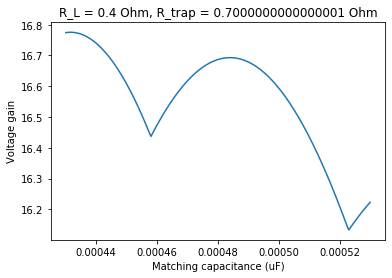

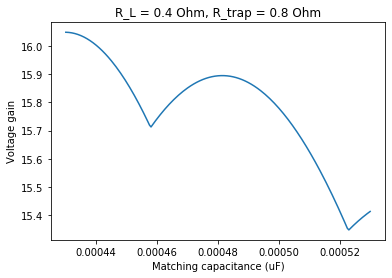

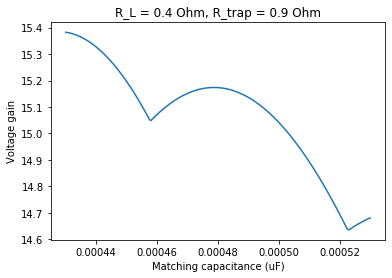

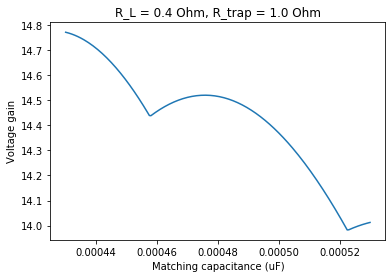

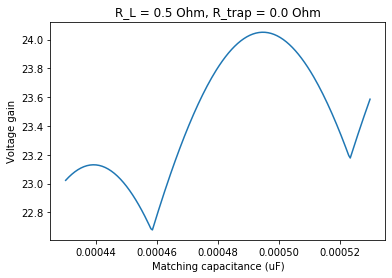

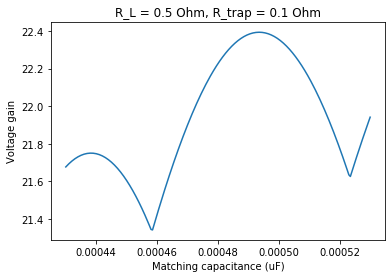

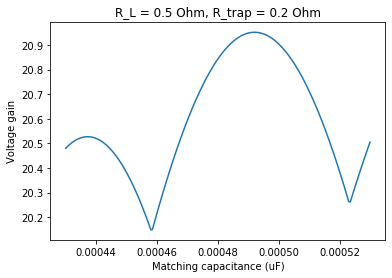

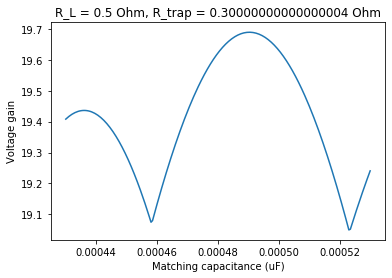

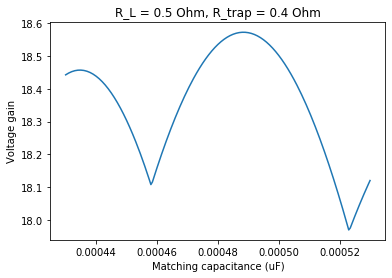

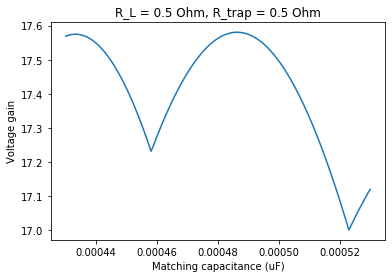

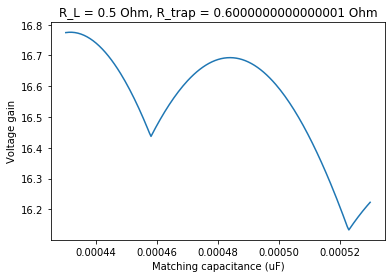

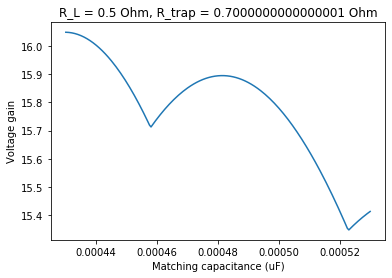

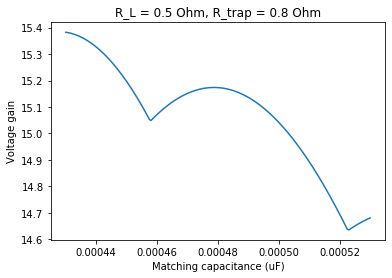

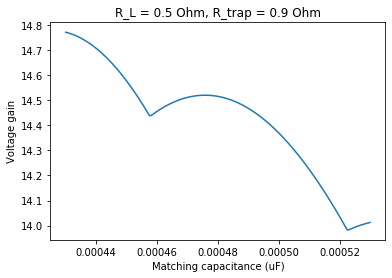

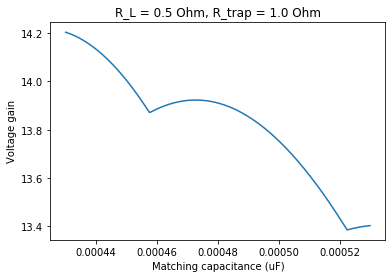

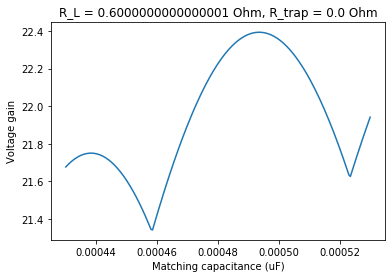

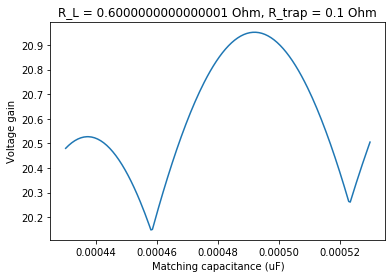

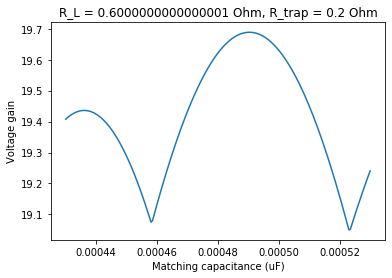

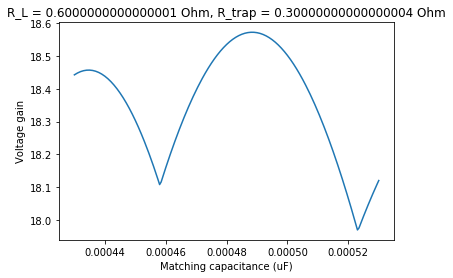

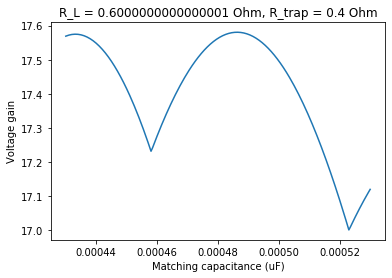

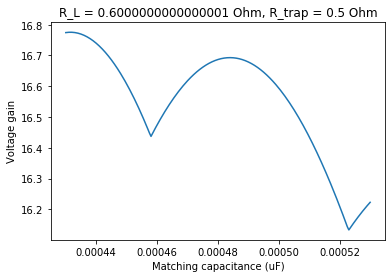

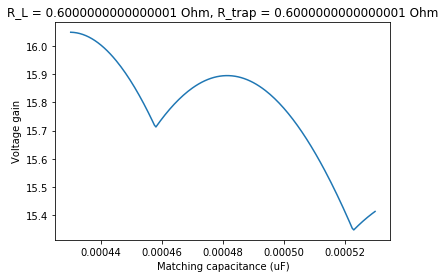

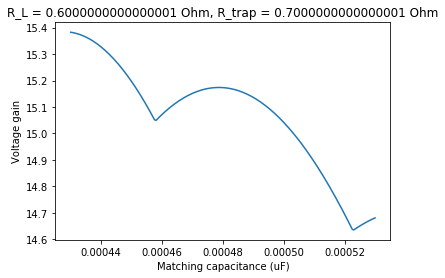

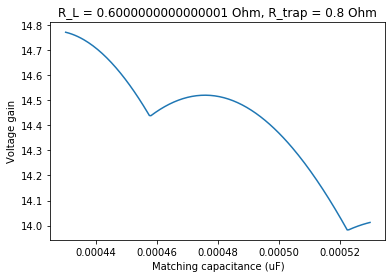

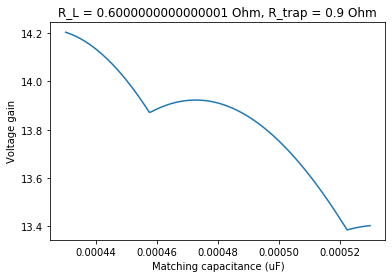

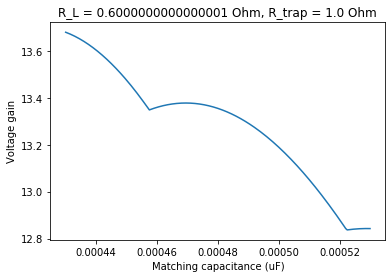

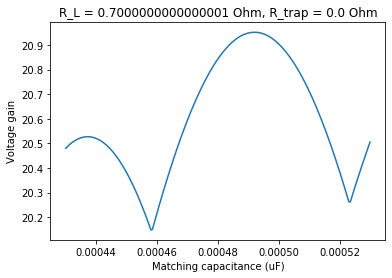

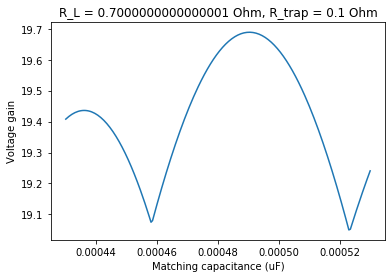

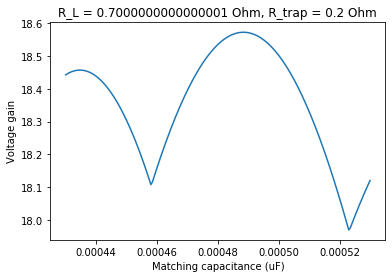

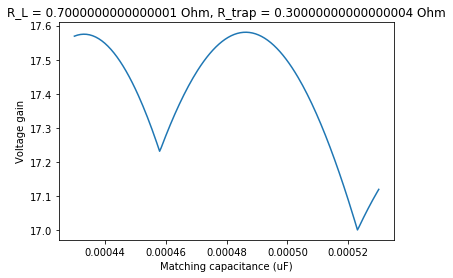

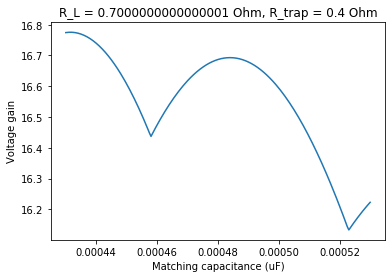

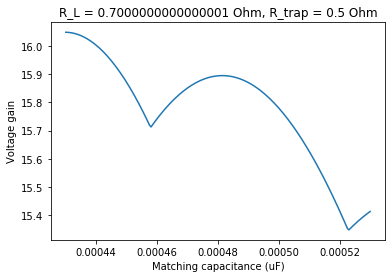

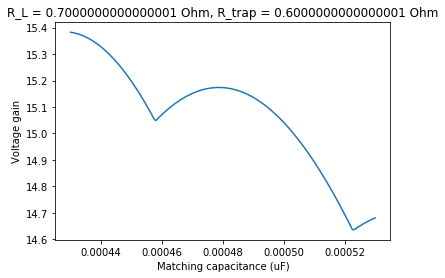

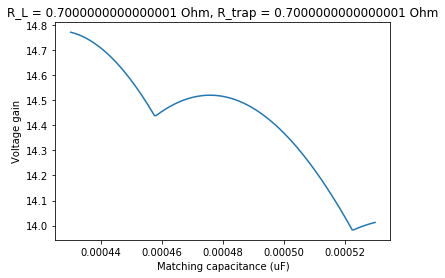

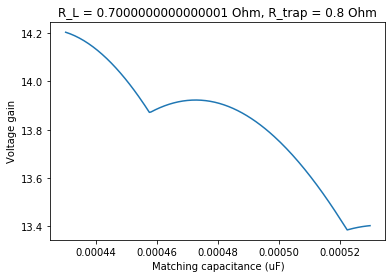

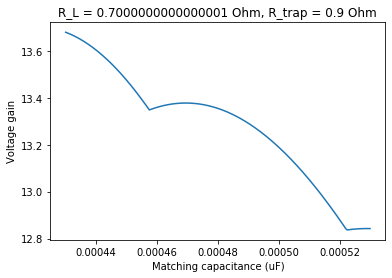

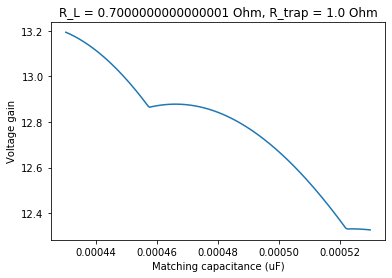

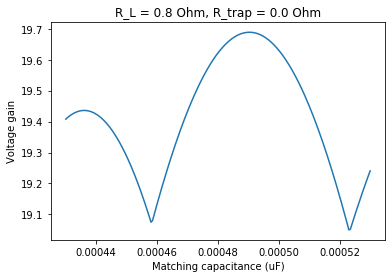

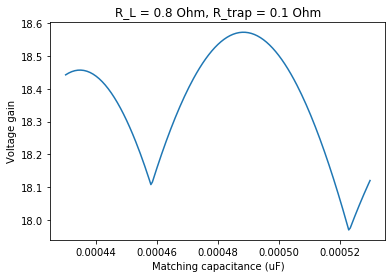

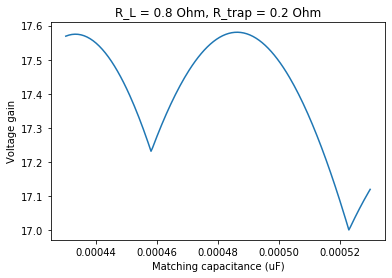

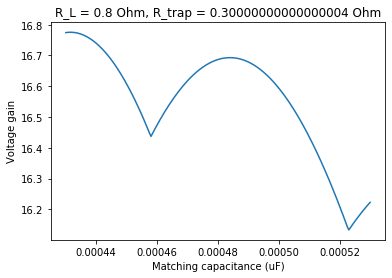

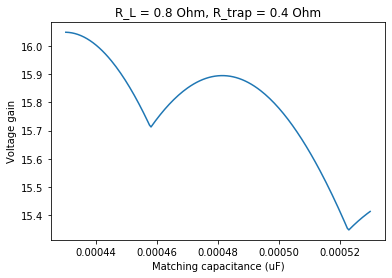

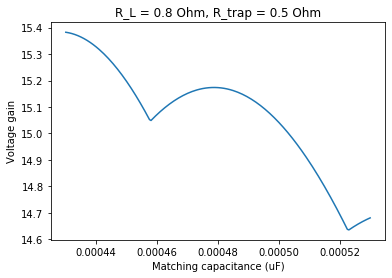

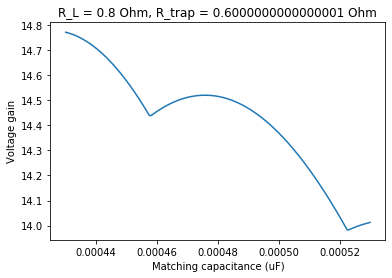

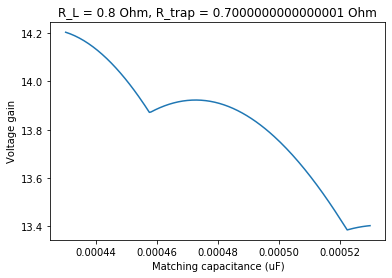

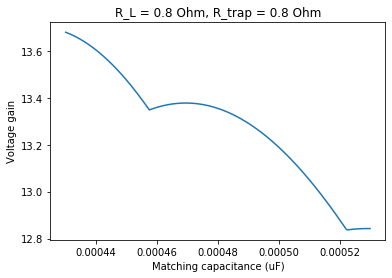

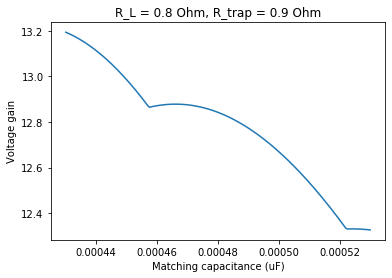

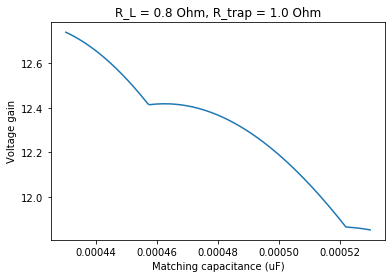

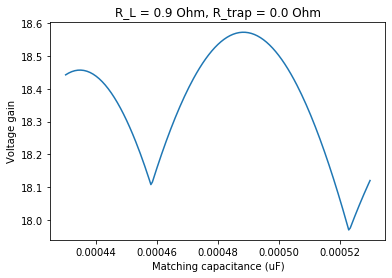

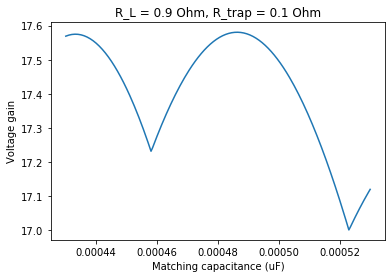

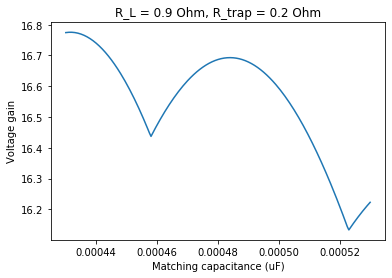

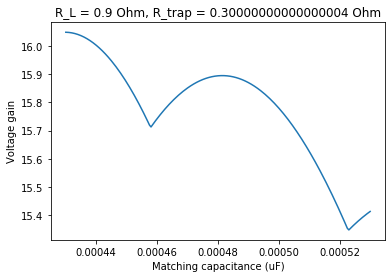

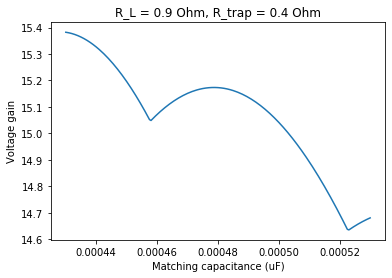

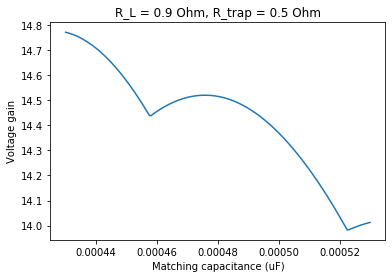

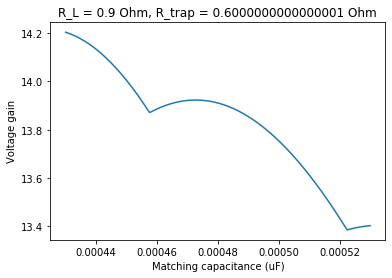

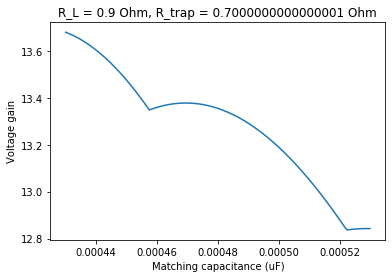

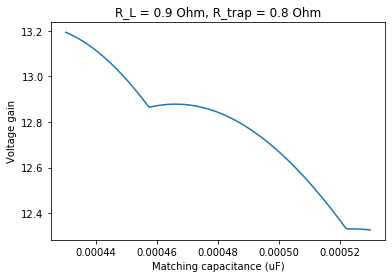

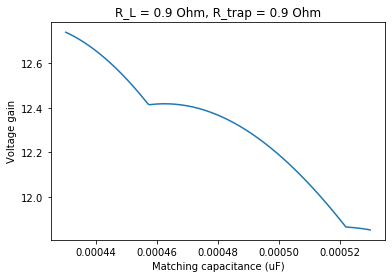

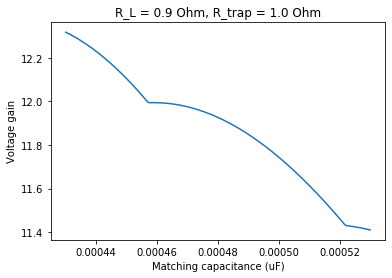

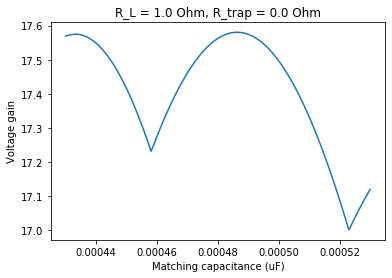

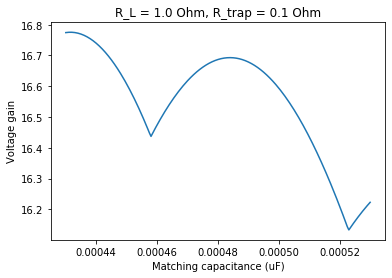

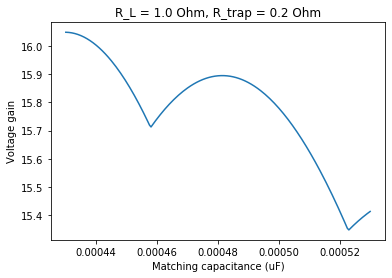

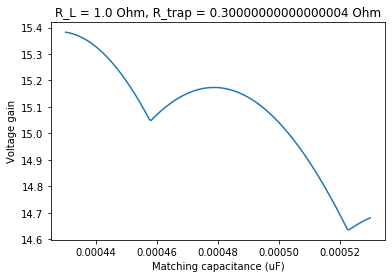

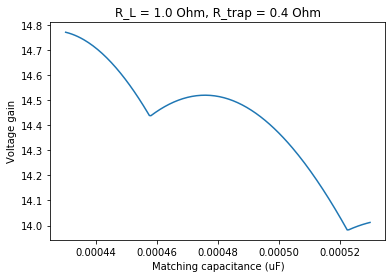

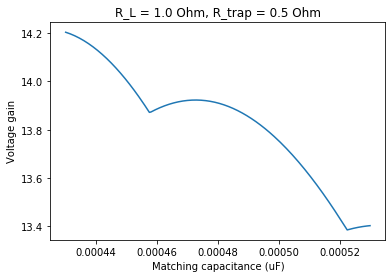

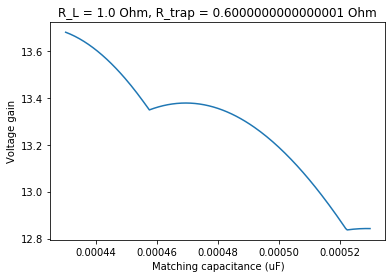

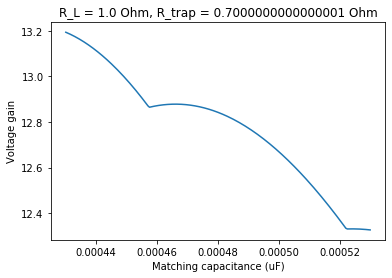

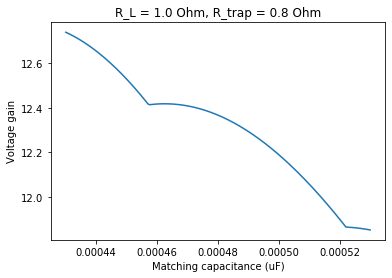

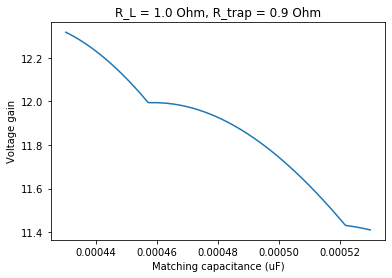

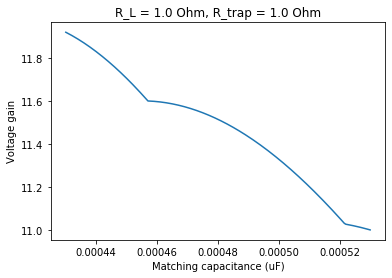

In [85]:
test = Resonator(Ct = 13.022e-6, # uF
                 L = 0.83,
                 N = 501)
Rs = np.linspace(0,1,11)
Rts = np.linspace(0,1,11)
for R in Rs:
    for Rt in Rts:
        test.relationWithCm(R = R, Rt = Rt, pos = 111,Cms = np.linspace(4.3e-4, 5.3e-4,201))

<IPython.core.display.Javascript object>


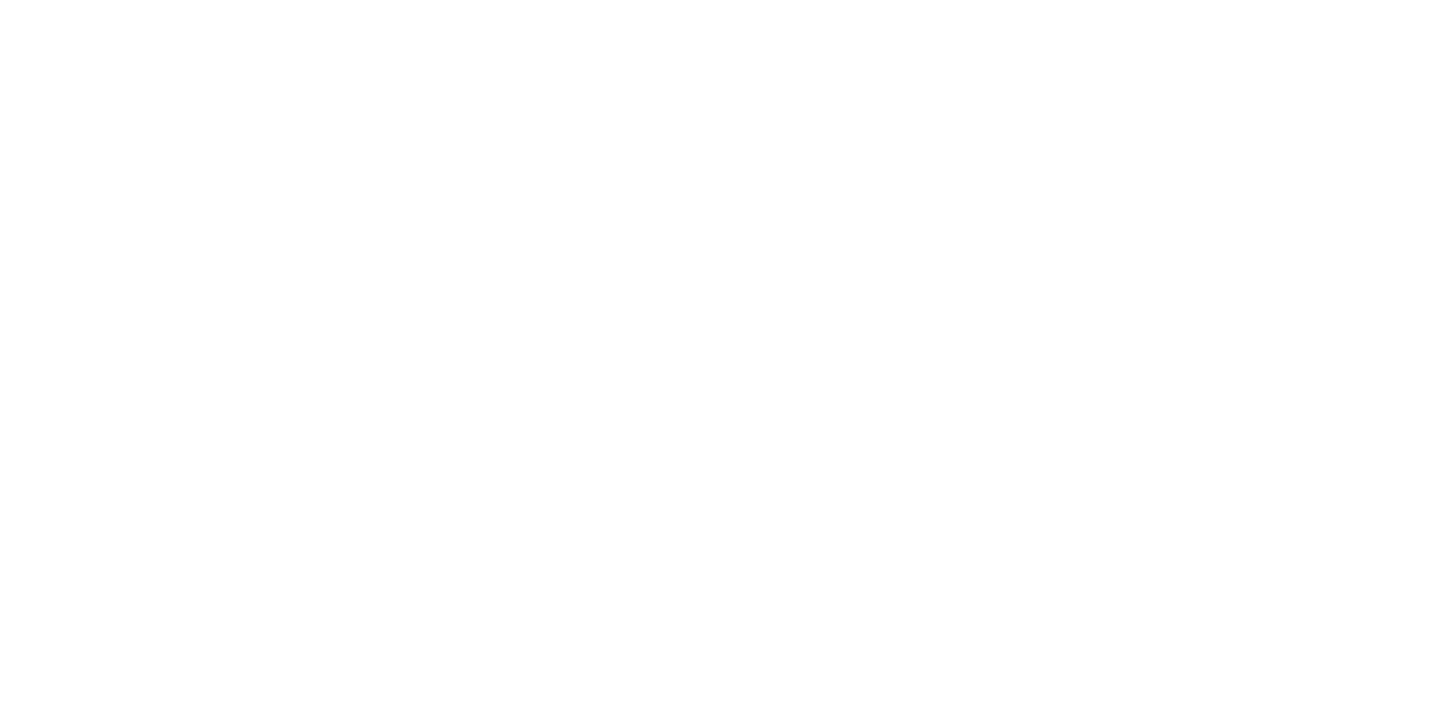

<IPython.core.display.Javascript object>


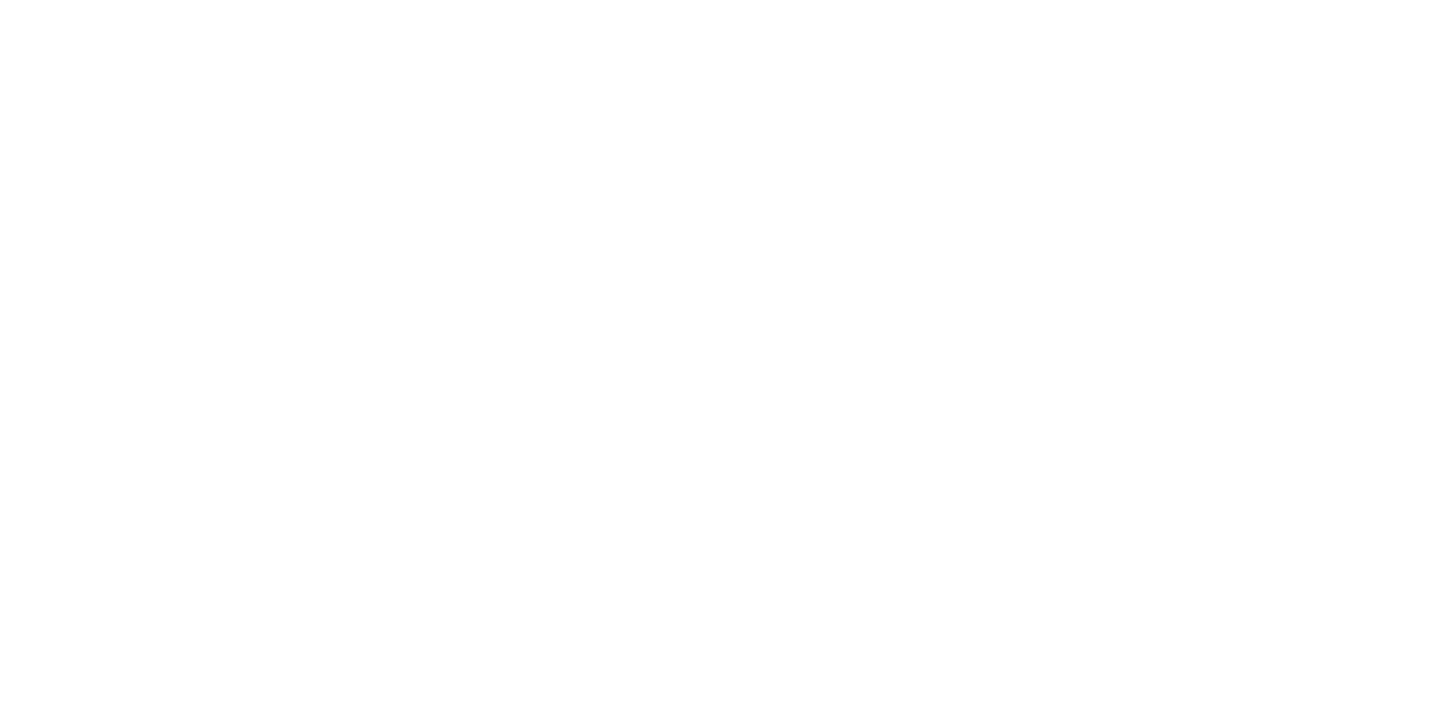

In [89]:
test = Resonator(Ct = 13.558e-6, # uF
                 L = 0.901,
                 N = 501)
N = 501
Cms = np.linspace(1e-4, 1.5e-3, N)
freqs = np.linspace(40,80,5*N)
Rs = np.linspace(0, 2, N)
Rts = np.linspace(0, 2, N)
Cm = 572e-6

Q = np.array([[0 for x in range(N)] for y in range(N)])

i,j = 0,0
for R in Rs:
    j = 0
    for Rt in Rts:
        Q[i][j], fc = test.CalculateQ(freqs, Cm, R, Rt)
        j+=1
    i+=1

Rsm, Rtsm = np.meshgrid(Rs, Rts)
plot_3d(Rsm,Rtsm,Q-66)

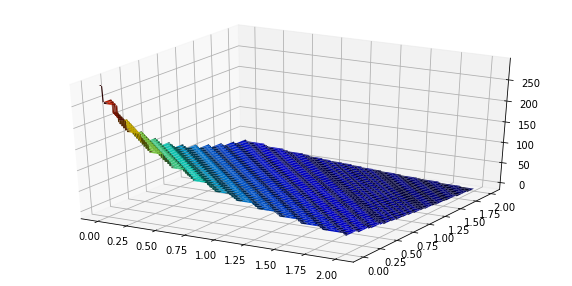

In [91]:
plot_3d(Rsm,Rtsm,Q-66)